In [70]:
import torch
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from robustbench import load_model
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os


In [71]:
train_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=196, shuffle=False, num_workers=4)
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified


In [72]:
def load_model_normalizer(i):
    if i==1:
        model = load_model(model_name='Standard', dataset='cifar10', threat_model='Linf').to(device)
    else:  
        model = load_model(model_name='Wu2020Adversarial_extra', dataset='cifar10', threat_model='Linf').to(device) 
    normalizer = lambda x: x
    for p in model.parameters():
        p.requires_grad_(False)
    model.eval()
    return model, normalizer

model, normalizer = load_model_normalizer(1)
model2, normalizer2 = load_model_normalizer(2)

In [73]:
target_classes = [0,1,2,3,4]
target_classes_str = "-".join([str(x) for x in target_classes])
target_images = []
to_tensor = transforms.ToTensor()
for i, tc in enumerate(target_classes):
    target_images.append(to_tensor(Image.open(f'./data/CIFAR10/cifar10_target_{tc}.png')))
    target_images[-1] = target_images[-1][:3]
target_images = torch.stack(target_images, dim=0)

with torch.no_grad():
    preds = torch.softmax(model(normalizer(target_images.to(device))), dim=-1).cpu().detach().numpy()
    predicted_classes = np.argmax(preds, axis=1)
    confidence_levels = np.max(preds, axis=1)
    print(predicted_classes)
    print(confidence_levels)


[0 1 2 3 4]
[0.9999938  0.999995   0.99999547 0.99999976 0.9999981 ]


## "Running attack on examples..."

In [74]:
def dict_combine(d1, d2):
    for k in d2:
        if d2[k] is None:
            continue
        if k in d1:
            if d1[k] is None:
                continue
            d1[k] = torch.cat((d1[k], d2[k]), dim=0)
        else:
            d1[k] = d2[k]
    return d1

def prod(x):
    p = 1
    for i in x:
        p = p*i
    return p

def get_nullspace_projection(J, v):
    y_hat = torch.sum(J*v, -1, keepdim=True)/torch.sum(J * J, -1,  keepdim=True)
    x = v - (J * y_hat)
    # computing othogonal projection for pert with positive inner product as well
    return x

def measure_width(img, model, normalizer, index, dir_vec, distances = [5, 10, 15, 20, 25, 30], num_vecs=256):
    # print('Entered measure_width')
    softmax = torch.nn.Softmax(dim=-1)
    init_confidence = softmax(model(normalizer(img.clamp(0,1))))[:, index]
    rand_vecs = torch.randn(num_vecs, *img.shape[1:]).to(init_confidence.device)
    if torch.linalg.vector_norm(dir_vec) == 0:
        return np.zeros((len(distances)+1, 2))
    dir_vec = dir_vec/torch.linalg.vector_norm(dir_vec)
    a = torch.sum(rand_vecs*dir_vec, dim=(1,2,3))
    rand_vecs = rand_vecs - torch.einsum("ij, jklm -> iklm" ,a.unsqueeze(-1), dir_vec)
    rand_vecs = rand_vecs/torch.linalg.vector_norm(rand_vecs, dim=(1,2,3), keepdim=True)
    confs = [torch.Tensor((float(init_confidence), float(init_confidence)))]
    for i in distances:
        # print(i)
        pert_imgs = img + i*rand_vecs
        with torch.no_grad():
            pert_confs = softmax(model(normalizer(pert_imgs.clamp(0,1))))[:, index]
#         min_confs, max_confs = float(torch.min(pert_confs)), float(torch.max(pert_confs))
        confs.append(torch.quantile(pert_confs, q=torch.Tensor([0.05, 0.95]).to(pert_confs.device) ).cpu())
    confs = torch.stack(confs)
    return confs

def plot_images(images):
    with torch.no_grad():
        preds = torch.softmax(model(normalizer(images.to(device))), dim=-1).cpu().detach().numpy()
        predicted_classes = np.argmax(preds, axis=1)
        confidence_levels = np.max(preds, axis=1)
        # print(predicted_classes)
        # print(confidence_levels)

    #for model2
    with torch.no_grad():
        preds2 = torch.softmax(model2(normalizer2(images.to(device))), dim=-1).cpu().detach().numpy()
        predicted_classes2 = np.argmax(preds2, axis=1)
        confidence_levels2 = np.max(preds2, axis=1)
        
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axes[i].imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())  # Detach tensor before converting to numpy array
        axes[i].set_title(classes[predicted_classes[i]], fontsize=10, color='blue')  # Set title as class name
        axes[i].set_xlabel(confidence_levels[i], fontsize=8, labelpad=5, color='blue', ha='center')
        # axes[i].set_title(classes[predicted_classes2[i]], fontsize=10, color='red')  # Set title as class name
        # axes[i].set_xlabel(confidence_levels2[i], fontsize=8, labelpad=5, color='red', ha='center')
    # for i in range(5):
    #     global j
    #     if i == 3:
    #         fig, ax = plt.subplots(figsize=(7, 4))  
    #         ax.imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
    #         ax.set_title(classes[predicted_classes[i]], fontsize=10, color='blue')
    #         ax.set_xlabel(confidence_levels[i], fontsize=8, labelpad=5, color='blue', ha='center')
    #         plt.savefig(f'saved_images/attacks/image_{j}.png')
    #         j = j+1
    #         plt.close(fig) 

    plt.show()


In [75]:
def batch_level_set_traversal(model, normalizer, dataset, source_classes, target_image, target_class, stepsize, iterations, device, 
                           pthresh=0.05, inp=None, get_widths=False, get_confs_over_path=False, get_images=False, get_final_imgs=False, log_step=10, dfunc_list=[]):
    source_classes = source_classes.to(device)
    softmax = torch.nn.Softmax(dim=-1)
    if inp is None:
        inp = torch.Tensor(dataset).to(device)#.requires_grad_(True)
    else:
        inp = inp.detach().clone().to(device)#.requires_grad_(True)
    mask = torch.ones(*inp.shape, dtype=torch.bool).to(device)
    target_image = target_image.to(device)
    indices = torch.arange(len(inp))
    with torch.no_grad():
        pred = model(normalizer(inp.clamp(0,1)))
    init_probs = softmax(pred)
    # print(source_classes, init_probs[indices, source_classes])
    init_labels = torch.argmax(init_probs, dim=-1)
    rel_img_mask = (init_labels == source_classes).cpu()
    # all_dataset = dataset
    # all_source_classes = source_classes
    dataset = dataset[rel_img_mask]
    source_classes = source_classes[rel_img_mask]
    inp = inp[rel_img_mask]
    init_probs = init_probs[rel_img_mask]
    indices = torch.arange(len(inp))
    target_image = target_image[rel_img_mask]

    widths_over_path, inp_over_path, confs_over_path, confs_over_path_target = [], [], [], []

    adv_delta = None
    adv_step_size = 2e-3
    width_distances = [0.5, 1, 1.5, 2]
    adv_pert = True

    init_target_layer_acts = source_classes

    loss = torch.nn.CrossEntropyLoss(reduction='sum')
    inp = inp + (4/255)*(torch.rand_like(inp)-0.5)
    inp = torch.clamp(inp, 0., 1.)
    inp.requires_grad_()
    print('Started')
    for i in range(iterations):
        pred = model(normalizer(inp))
        probs = softmax(pred)
        target_activations = pred
        cost = loss(target_activations, init_target_layer_acts)
        cost.backward()
        J = inp.grad.reshape(len(probs), prod(inp.shape[1:]))
        v = target_image.flatten(start_dim=1) - inp.flatten(start_dim=1)
        # v = target_image.flatten() - inp.flatten(start_dim=1)
        null_vec = get_nullspace_projection(J, v).reshape(inp.shape)

        if adv_delta is None:
            adv_delta = (adv_step_size/2) * J
        else:
            adv_delta = adv_delta + (adv_step_size/2) * J
        adv_delta = torch.clamp(adv_delta, -adv_step_size, adv_step_size)
                
        if i%log_step == 0:
            # print(f'Iteration {i}')
            if get_widths:
                # print(f'Getting widths at {i}')
                with torch.no_grad():
                    widths_at_i = []
                    for j in range(len(inp)):
                        if probs[j, source_classes[j]] < pthresh:
                            widths_at_i.append(np.zeros((len(width_distances)+1,2)))
                        else:
                            widths_at_i.append(measure_width(inp[j:j+1], model, normalizer, source_classes[j], null_vec[j:j+1], distances=width_distances))
                    widths_over_path.append(torch.stack(widths_at_i))
            if get_images:
                with torch.no_grad():
                    inp_over_path.append(inp.detach().cpu())

            if get_confs_over_path:
                confs_at_i = probs[indices, source_classes].detach().cpu()
                confs_at_i_target = probs[indices, target_class].detach().cpu()
                confs_over_path.append(confs_at_i)
                confs_over_path_target.append(confs_at_i_target)

        if adv_pert:
            new_inp = inp + stepsize*null_vec - adv_delta.reshape(inp.shape)
        else:
            new_inp = inp + stepsize*null_vec
        new_inp = torch.clamp(new_inp, 0.0, 1.0)
        
        with torch.no_grad():
            pred_probs = softmax(model(normalizer(new_inp)))

        mask = ((init_probs[indices,source_classes] - pred_probs[indices,source_classes] < pthresh)).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        # if ~ (mask.any()):
        #     print("Iterations stopped at:", i)
        #     break
        inp = (inp*(~mask) + new_inp*mask).detach()
        inp.requires_grad_()
        if(i%8 == 0):
            #Plots
            plot_images(inp)
    
    inp = inp.detach()
    with torch.no_grad():
        pred = model(normalizer(inp.clamp(0,1)))
    probs = softmax(pred)
    # print(probs[indices, source_classes])
    with torch.no_grad():
        if len(dfunc_list) == 0:
            dist_target = None
        else:
            dist_target = torch.stack([dfunc(inp, target_image).squeeze().detach().cpu() for dfunc in dfunc_list], dim=1)

    return {
        'source_images': dataset.cpu() if get_final_imgs else None,
        'final_images': inp.cpu() if get_final_imgs else None,
        'distances': dist_target,
        'widths_over_path': torch.stack(widths_over_path, dim=1) if get_widths else None,
        'confs_over_path': torch.stack(confs_over_path, dim=1) if get_confs_over_path else None,
        'confs_over_path_target': torch.stack(confs_over_path_target, dim=1) if get_confs_over_path else None,
        'imgs_over_path': torch.stack(inp_over_path, dim=1) if get_images else None,
        'labels': source_classes,
        }

example loader shapes:  1 torch.Size([5, 3, 32, 32]) torch.Size([5])
0


  0%|          | 0/1 [00:00<?, ?it/s]

Started


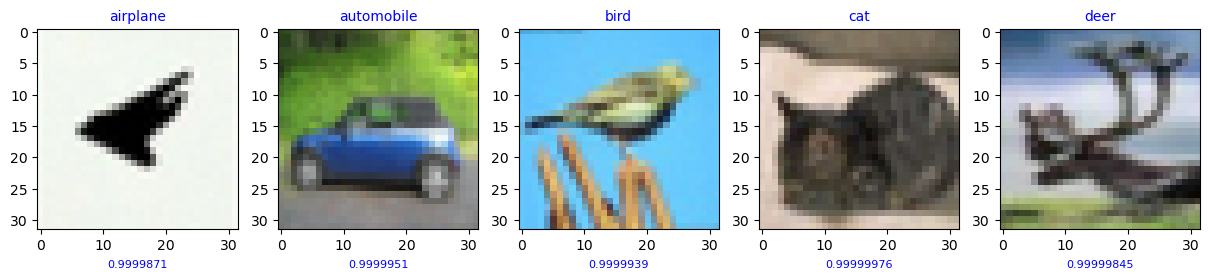

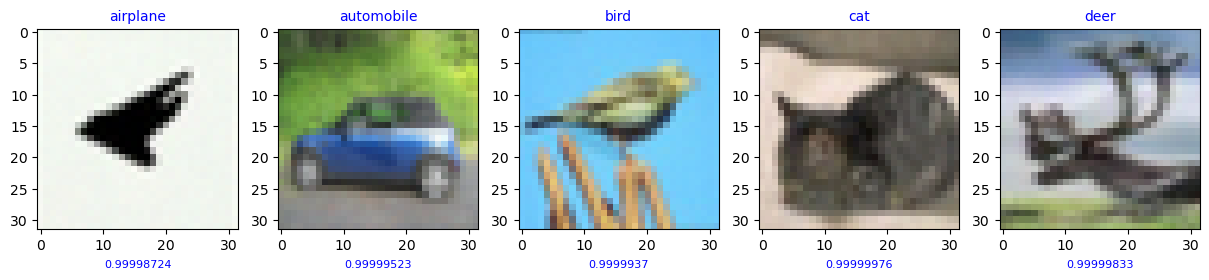

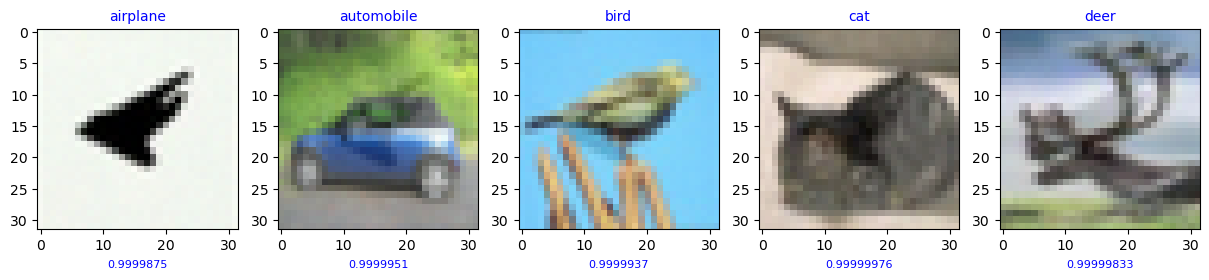

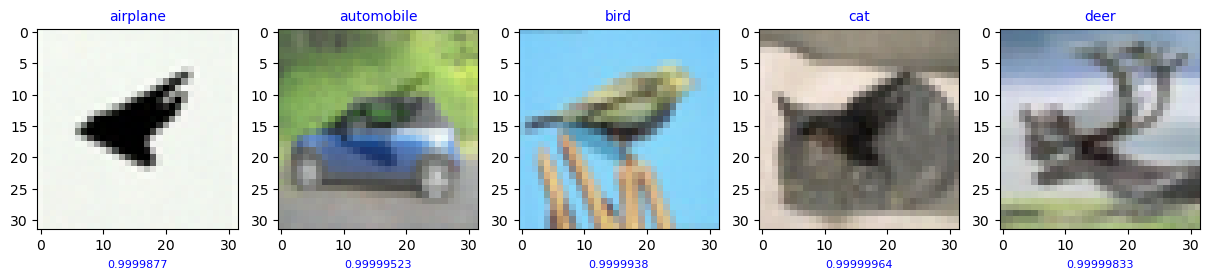

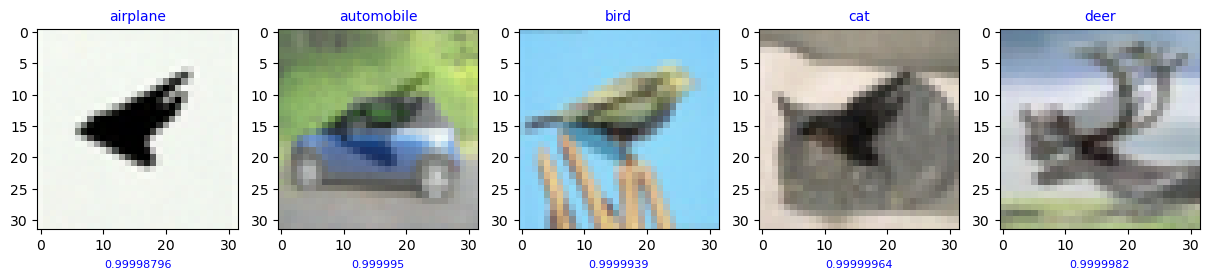

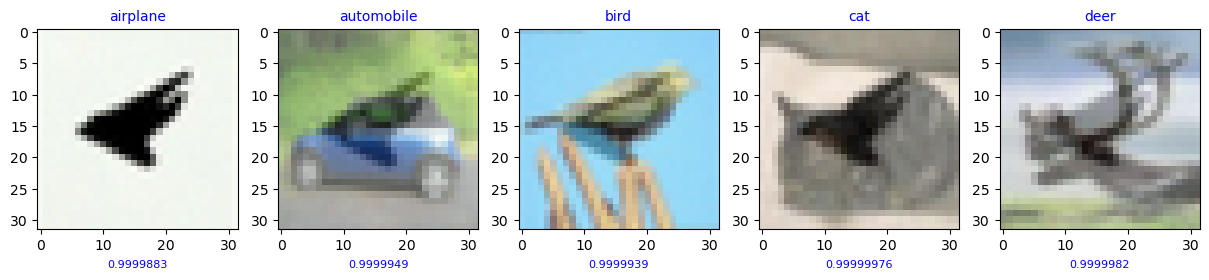

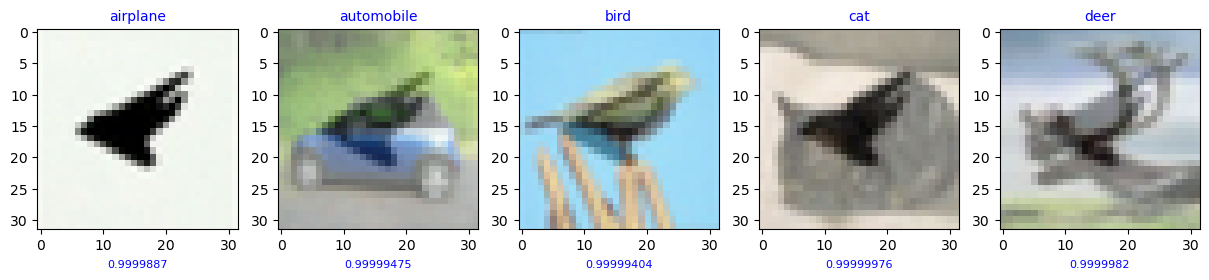

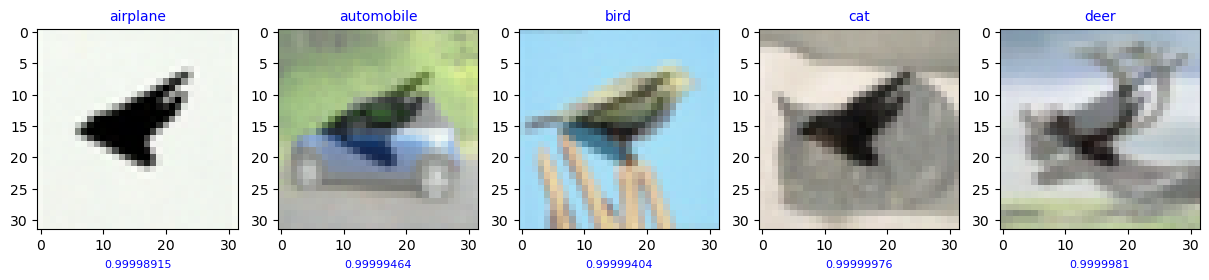

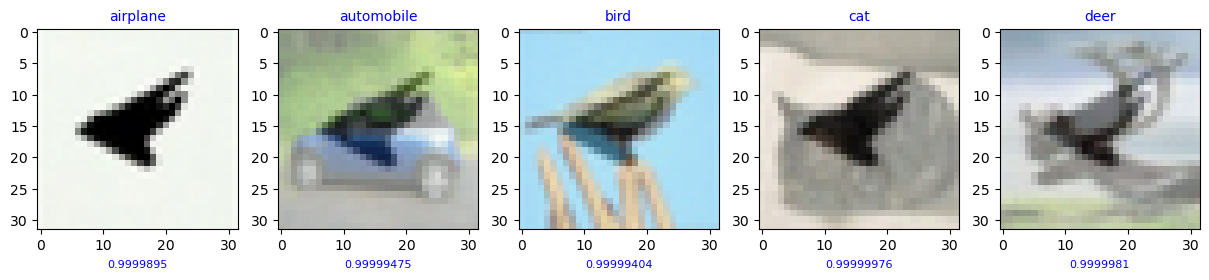

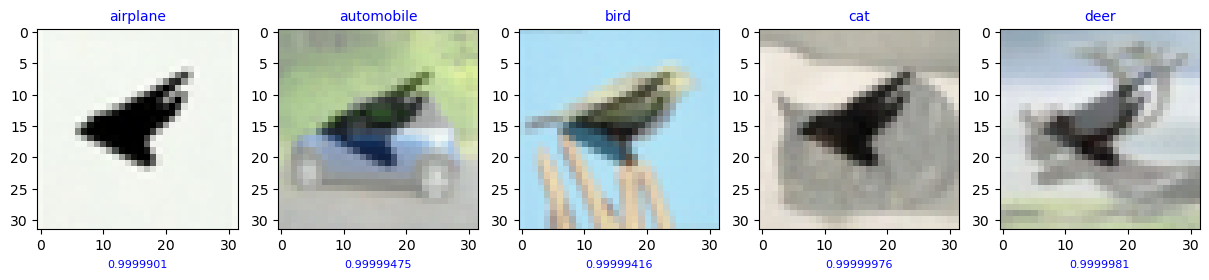

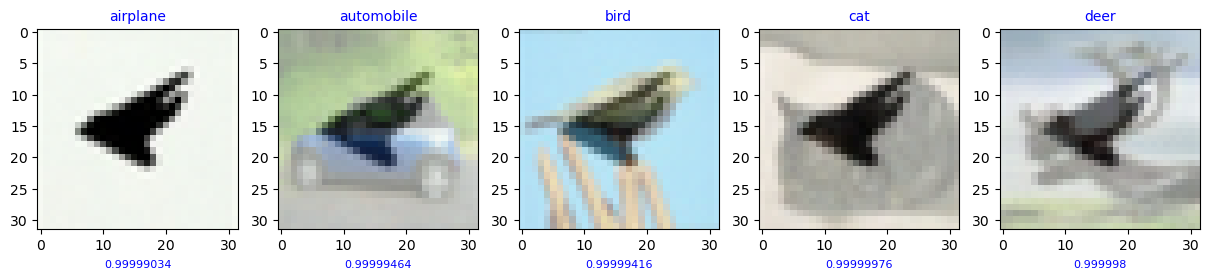

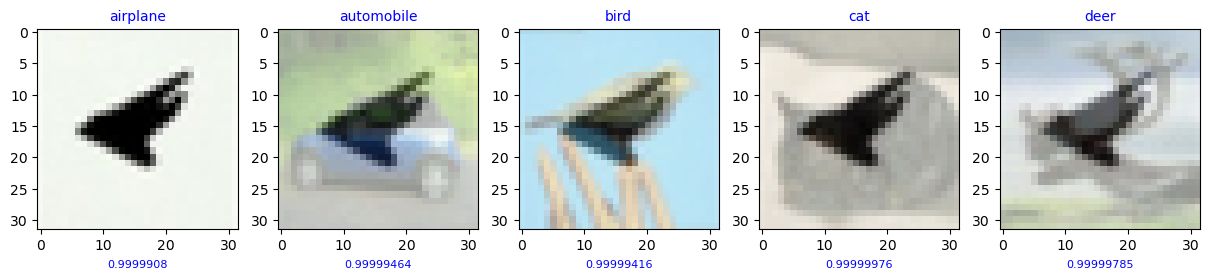

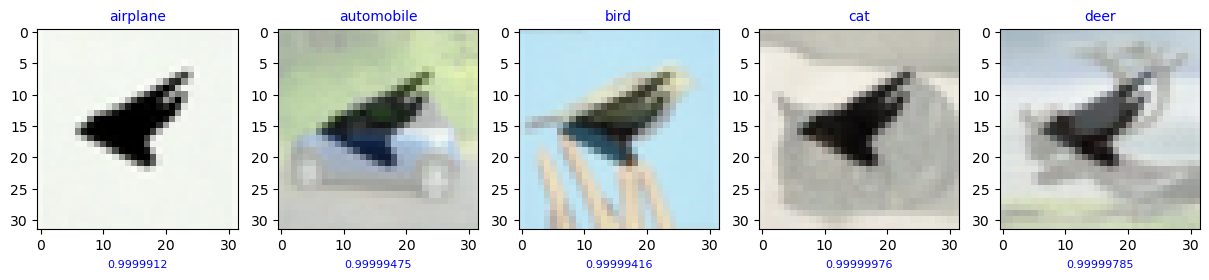

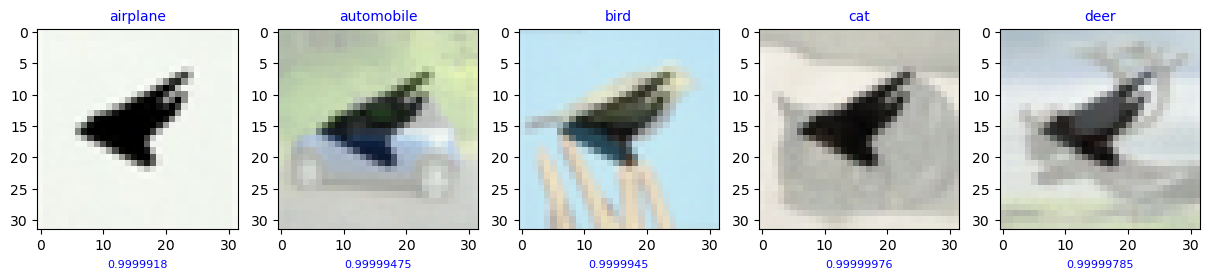

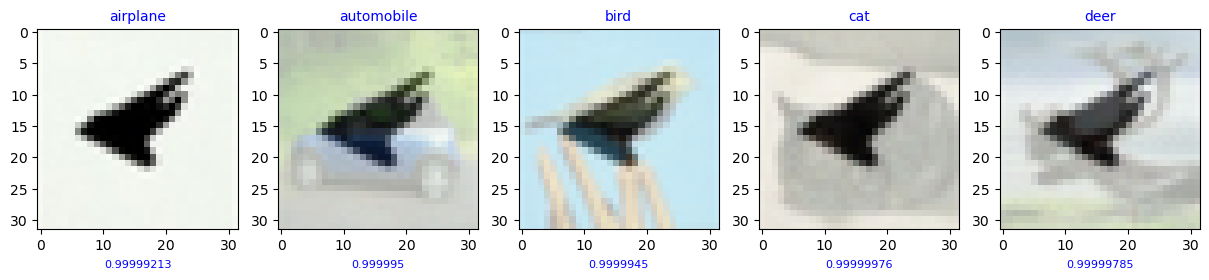

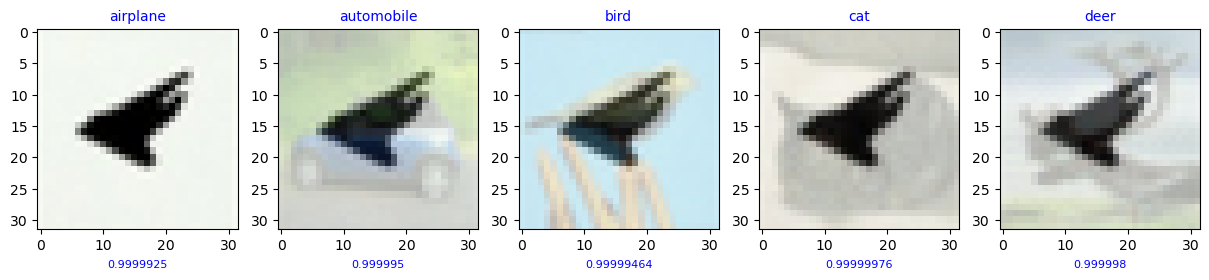

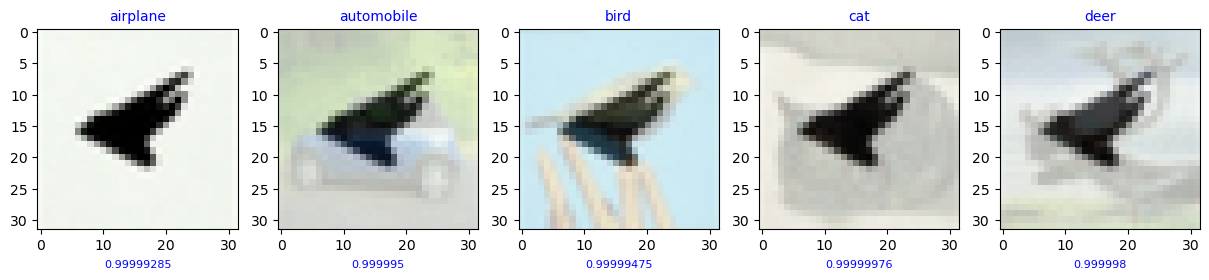

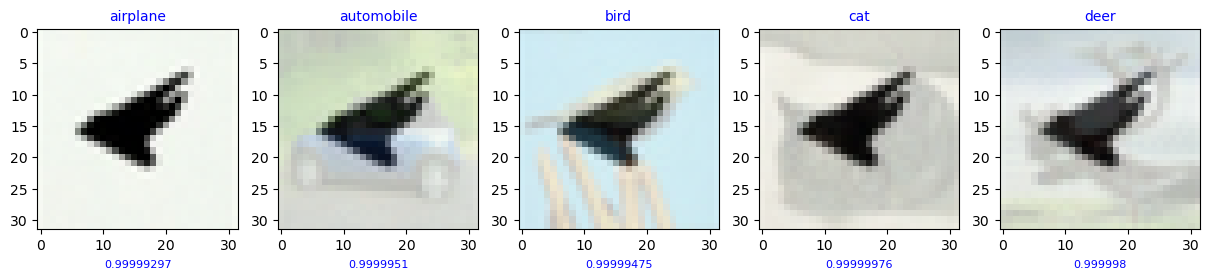

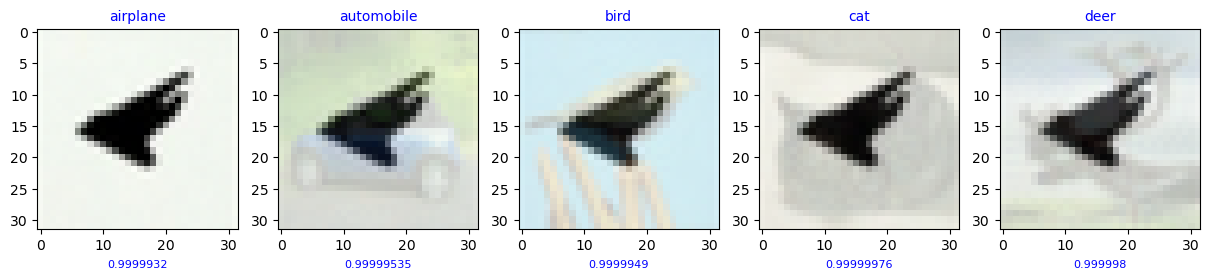

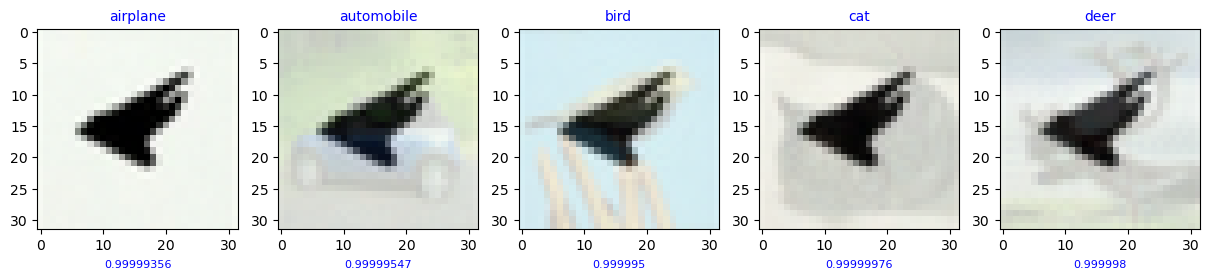

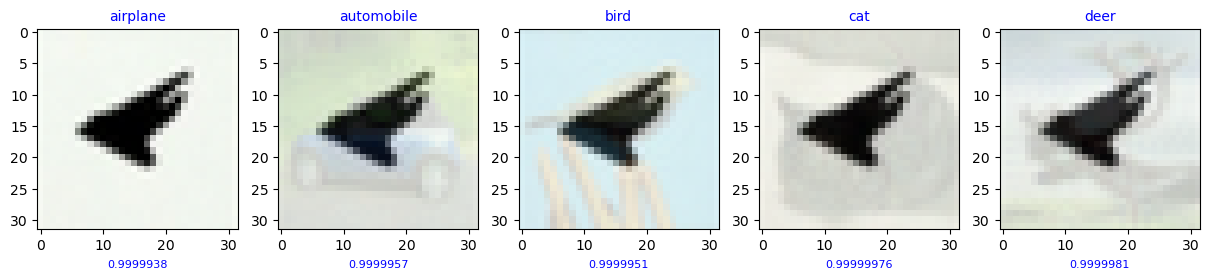

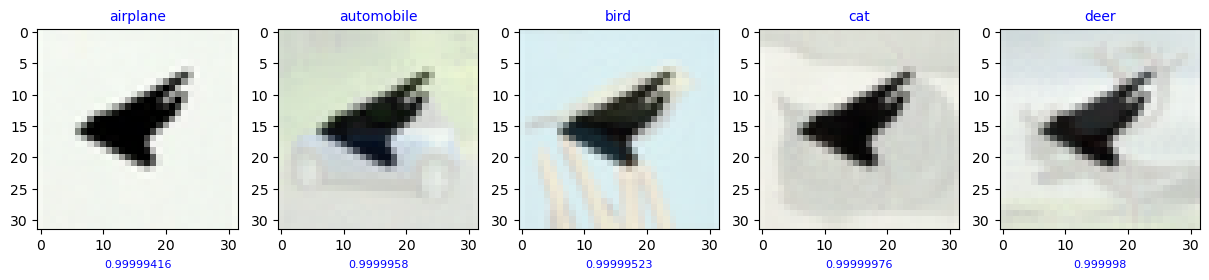

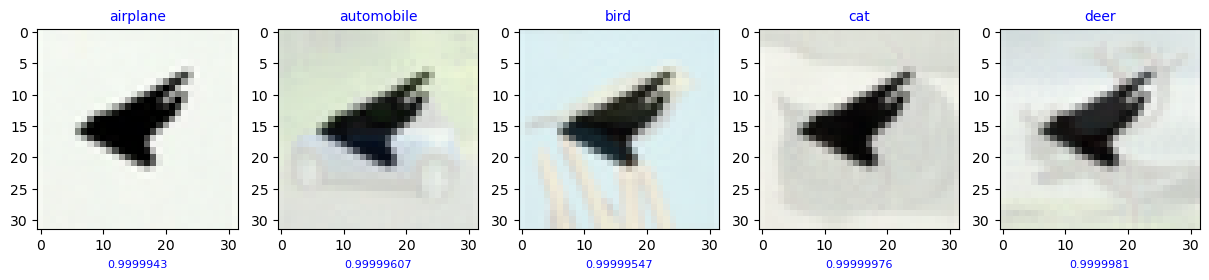

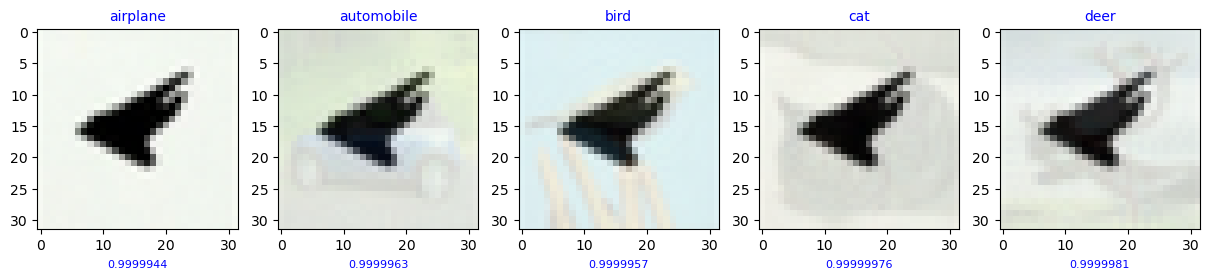

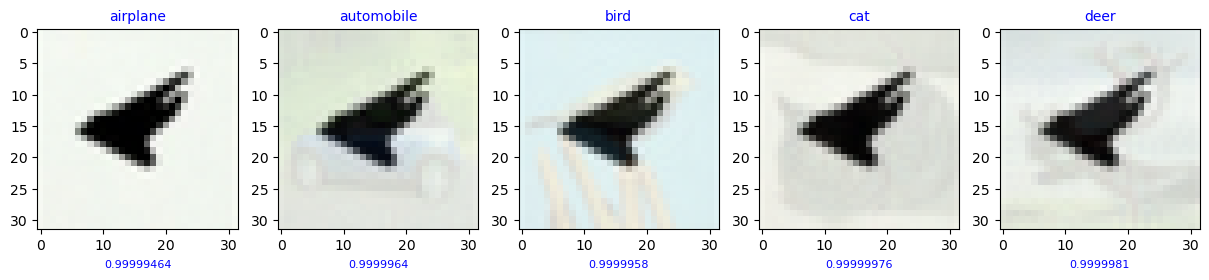

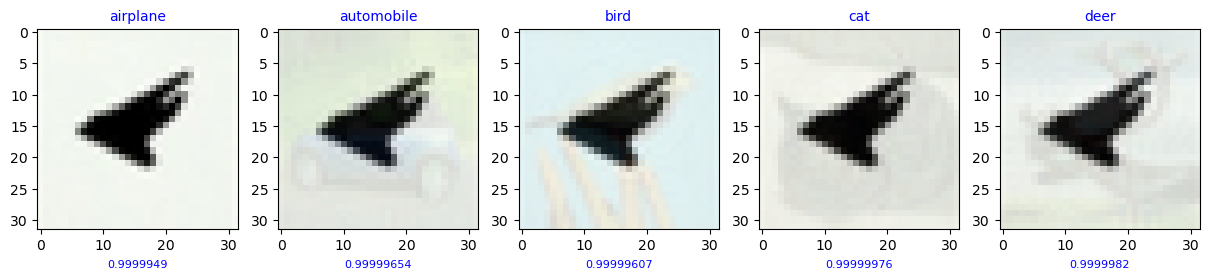

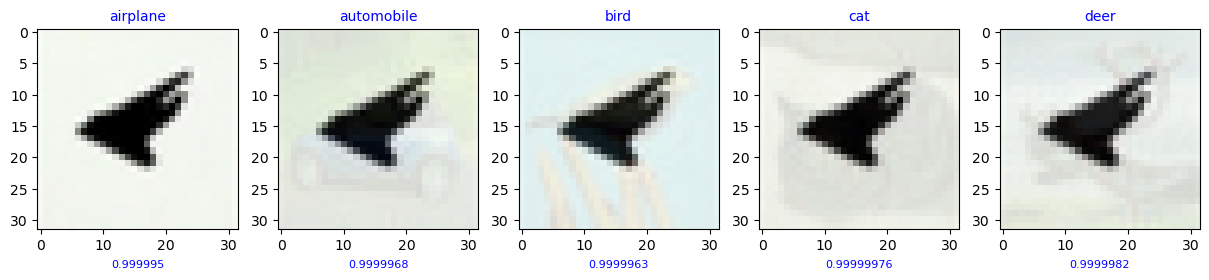

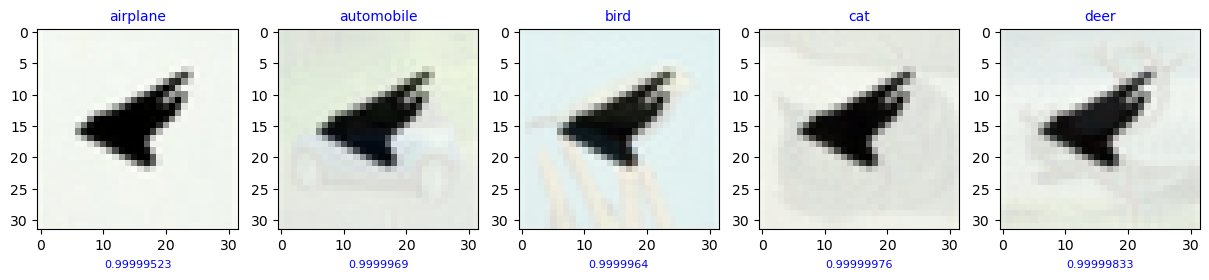

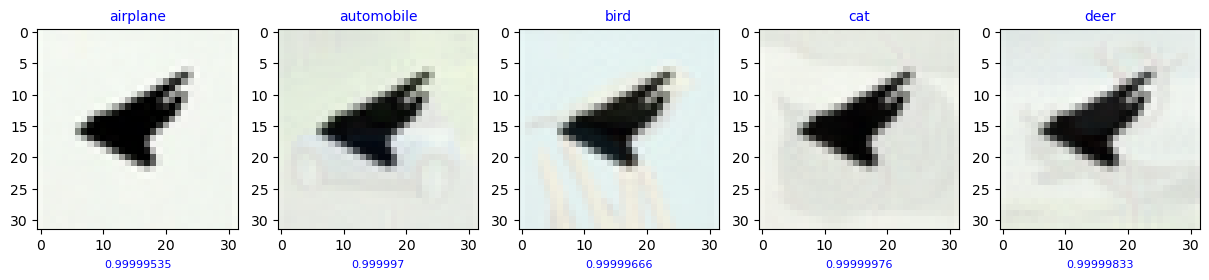

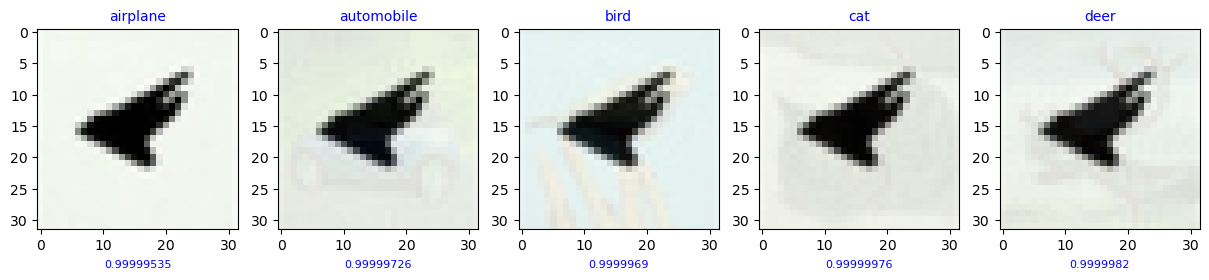

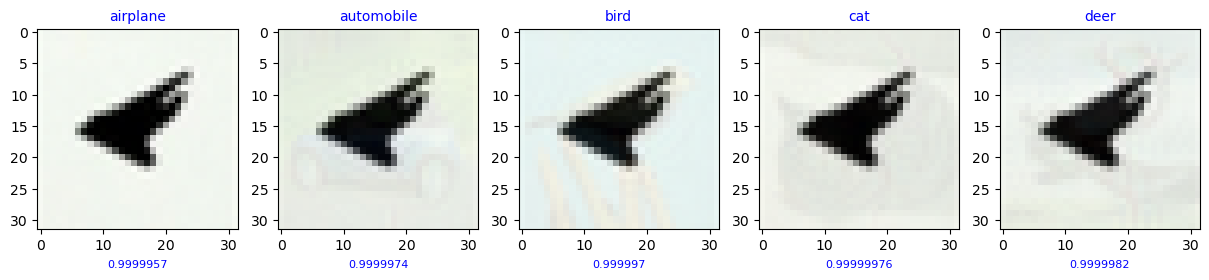

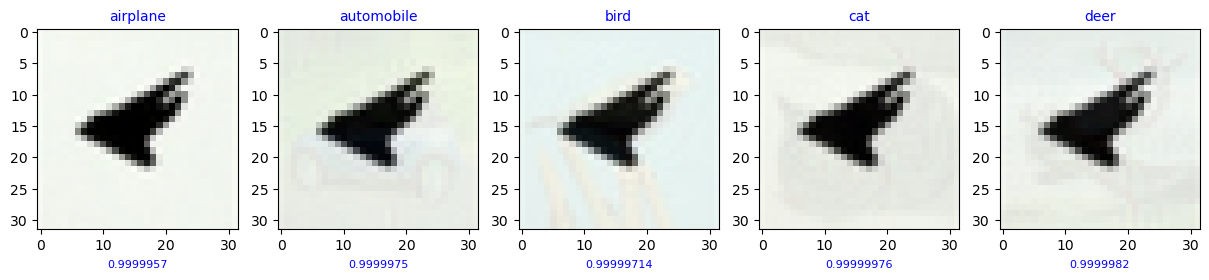

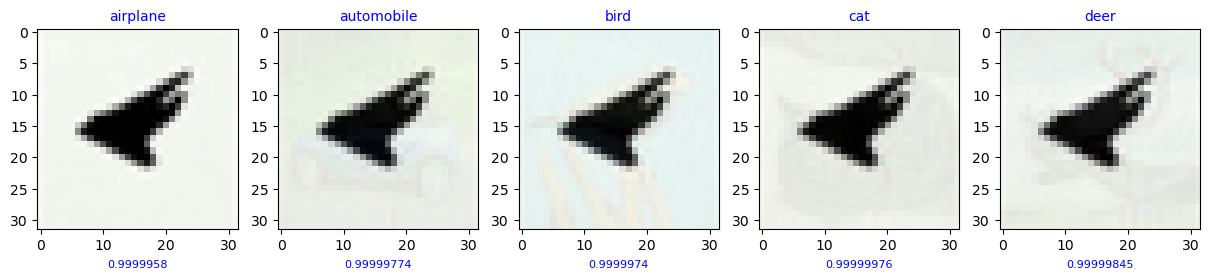

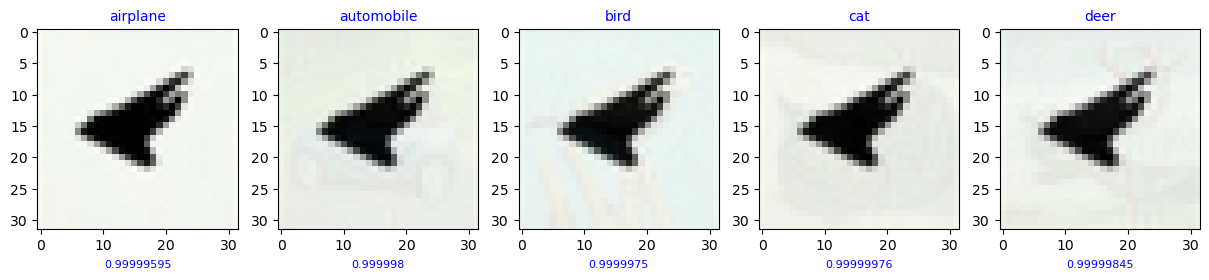

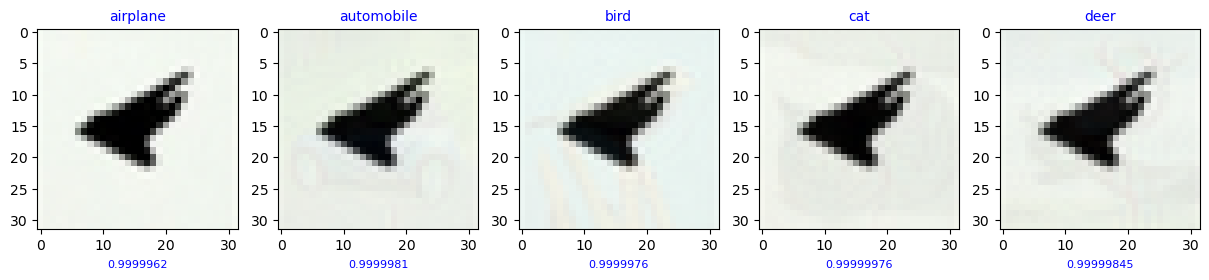

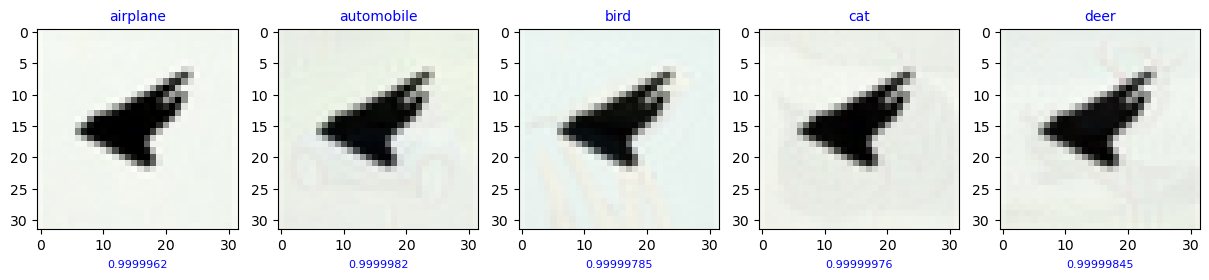

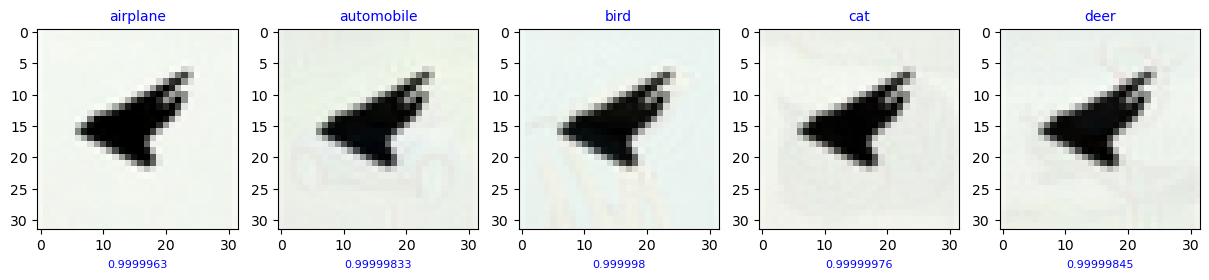

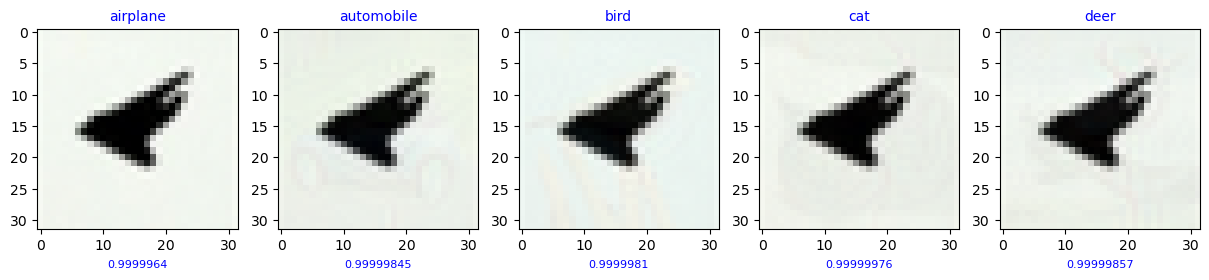

100%|██████████| 1/1 [00:35<00:00, 35.04s/it]


1


  0%|          | 0/1 [00:00<?, ?it/s]

Started


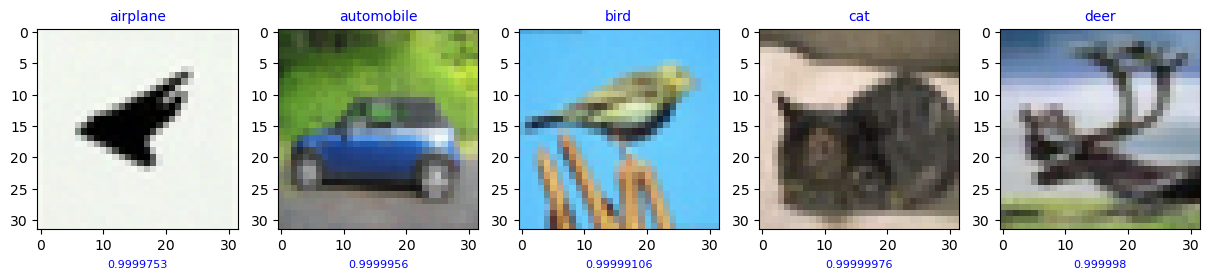

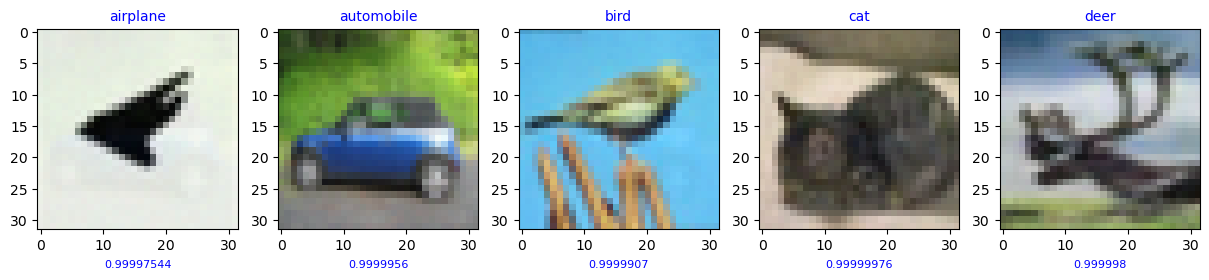

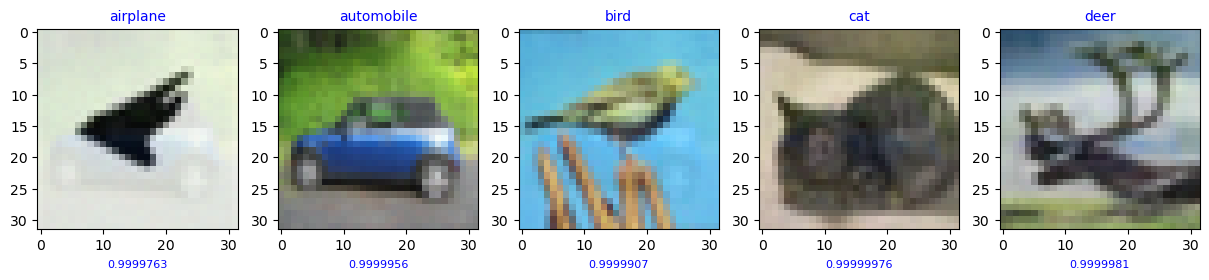

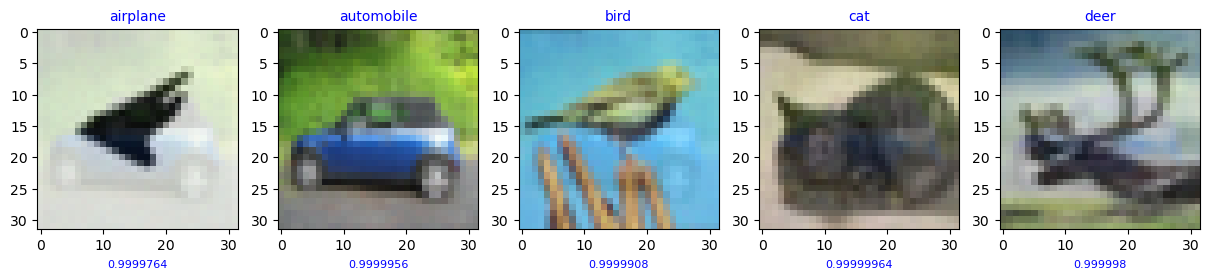

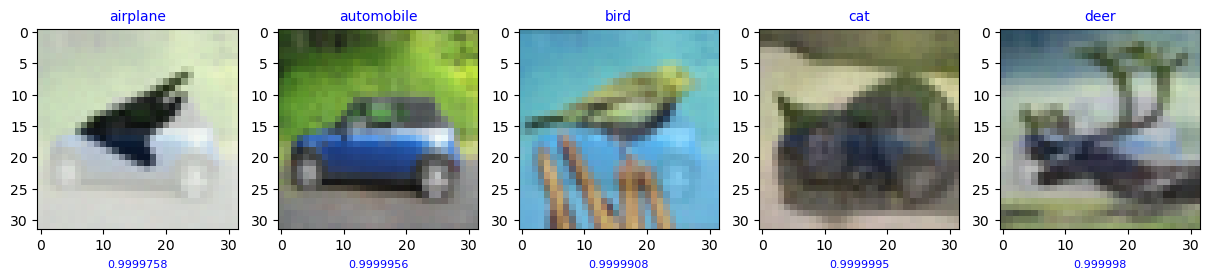

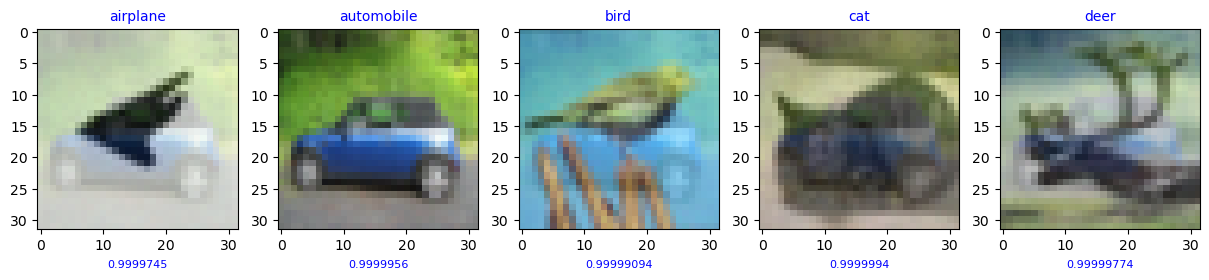

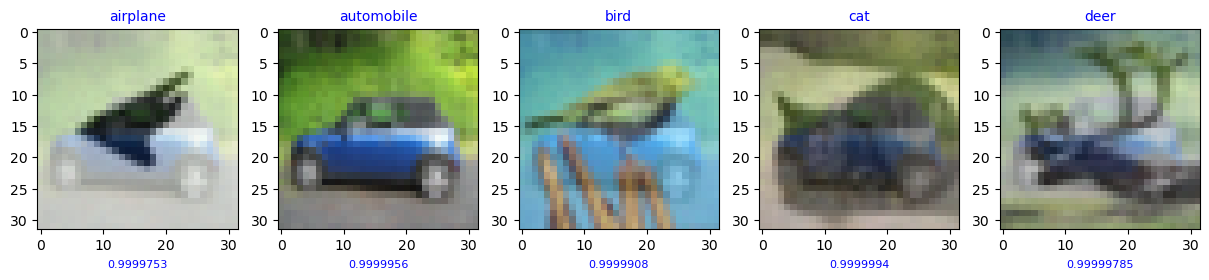

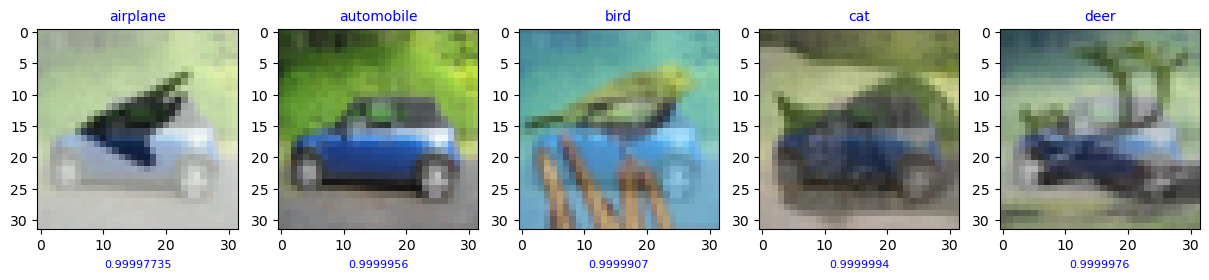

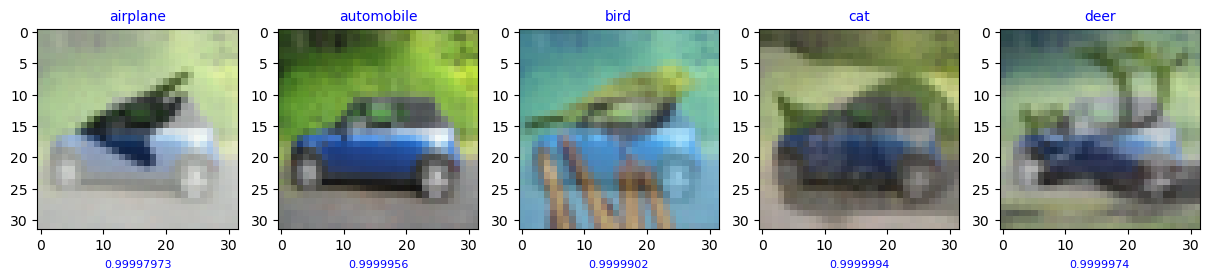

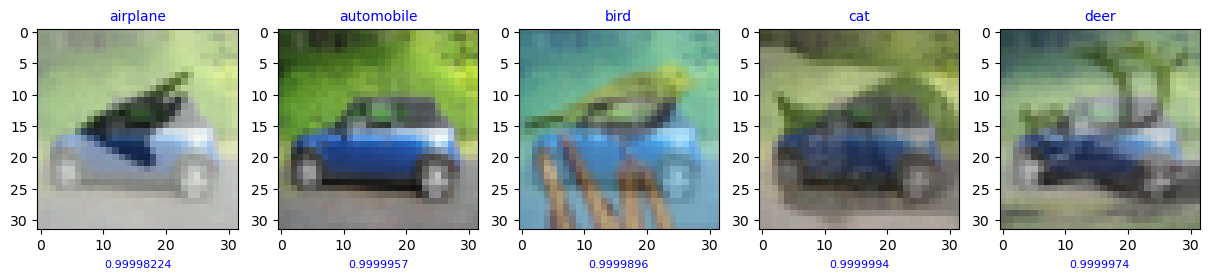

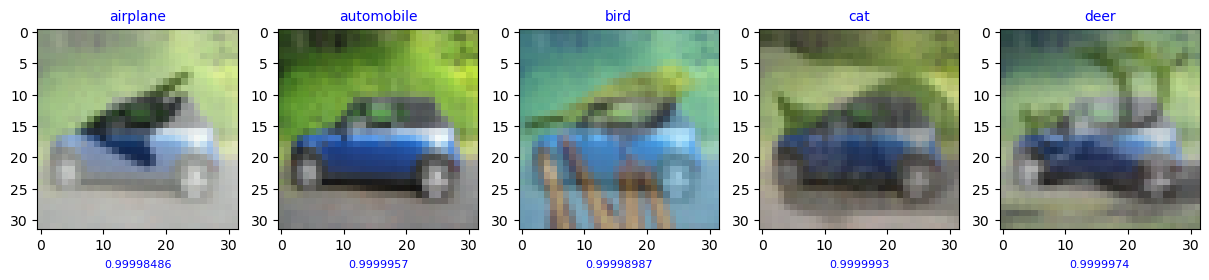

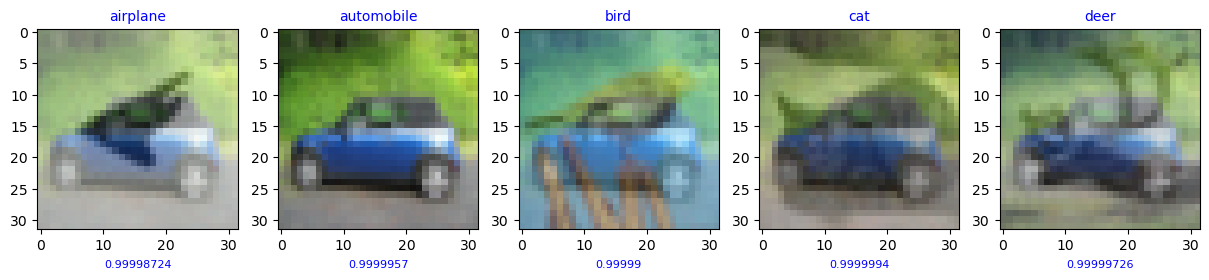

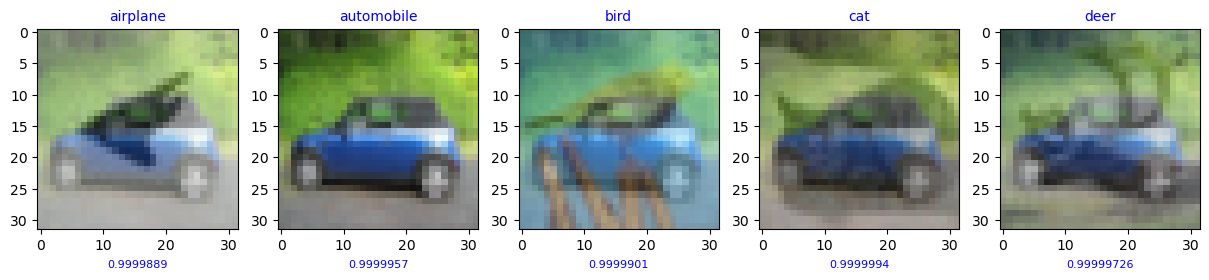

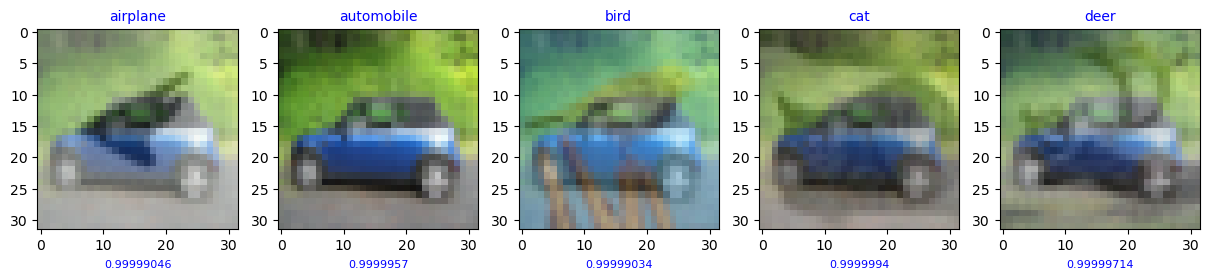

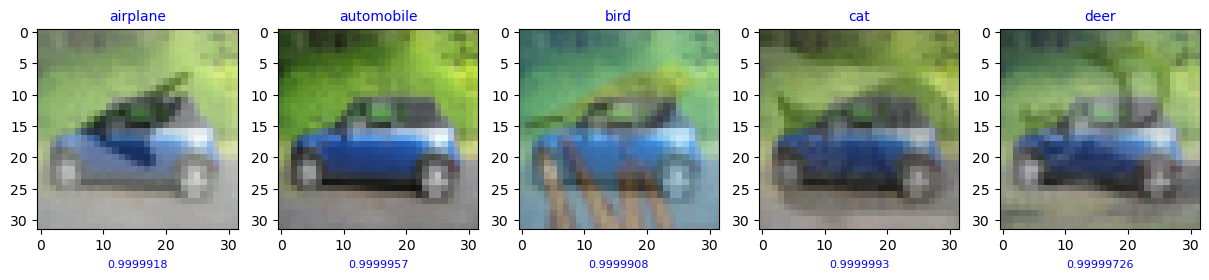

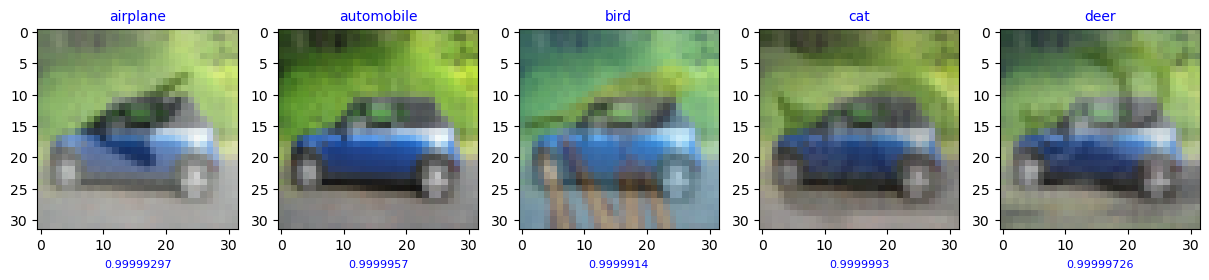

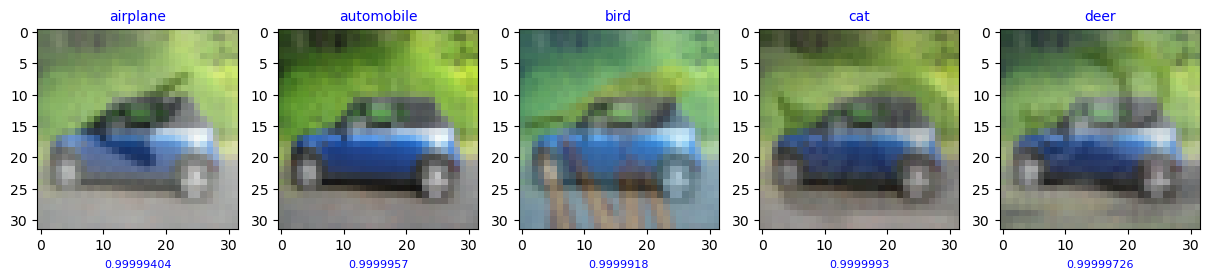

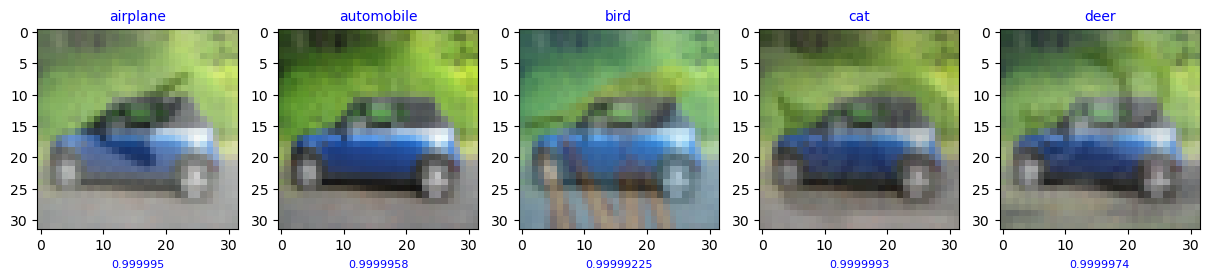

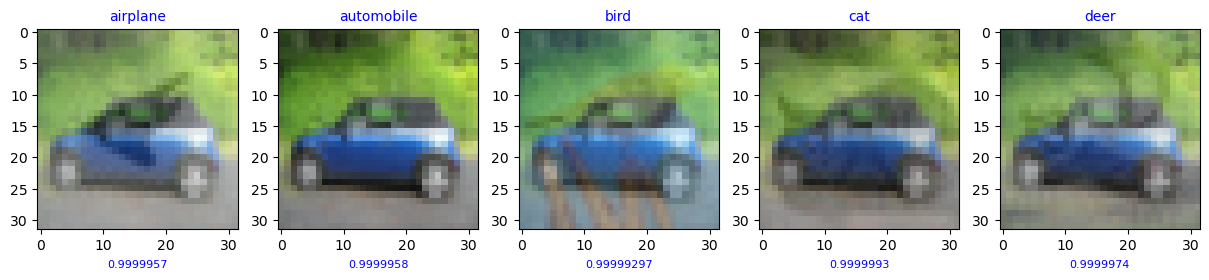

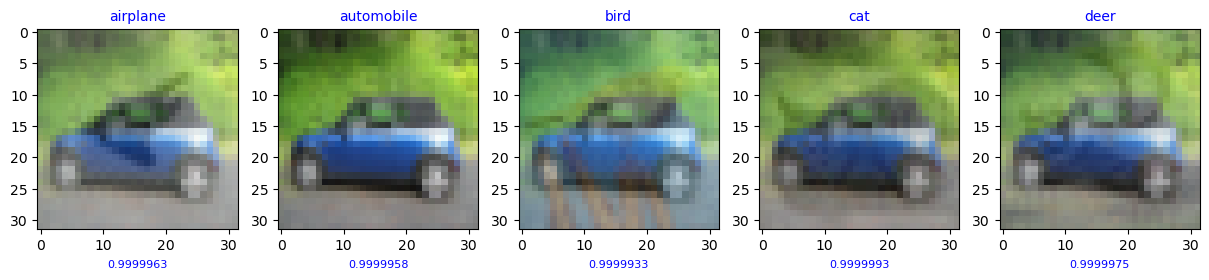

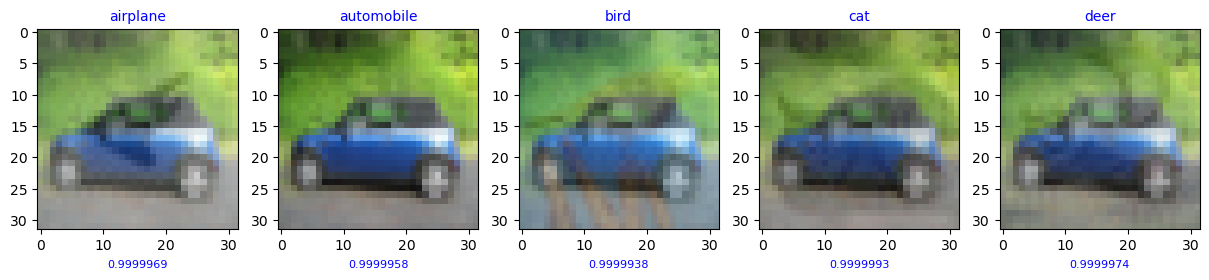

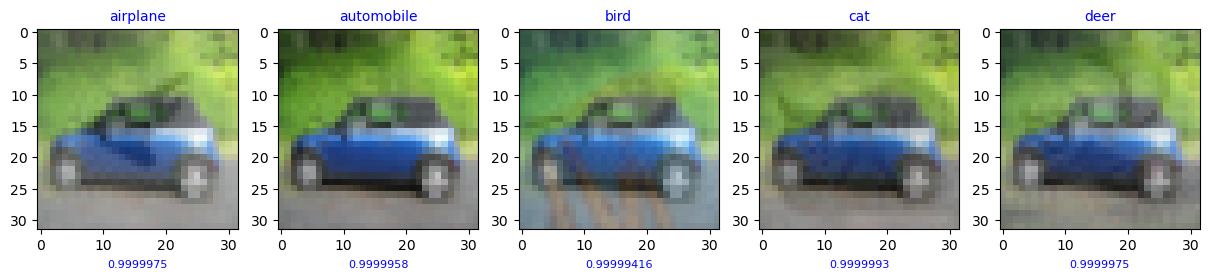

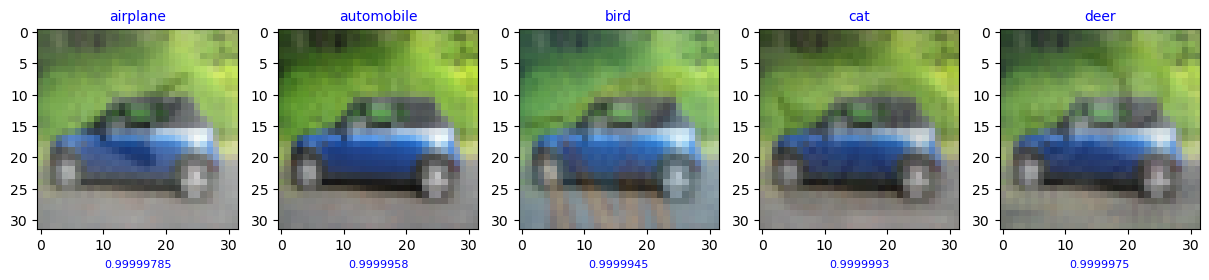

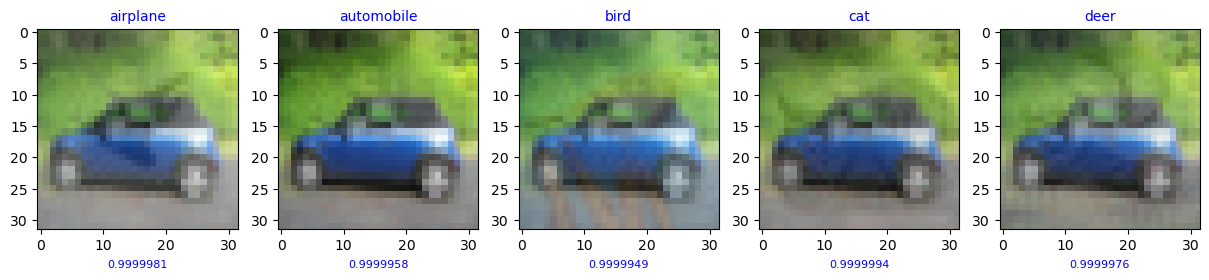

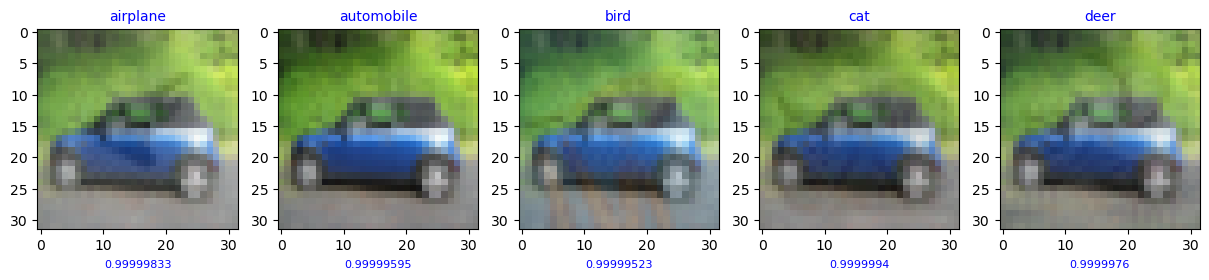

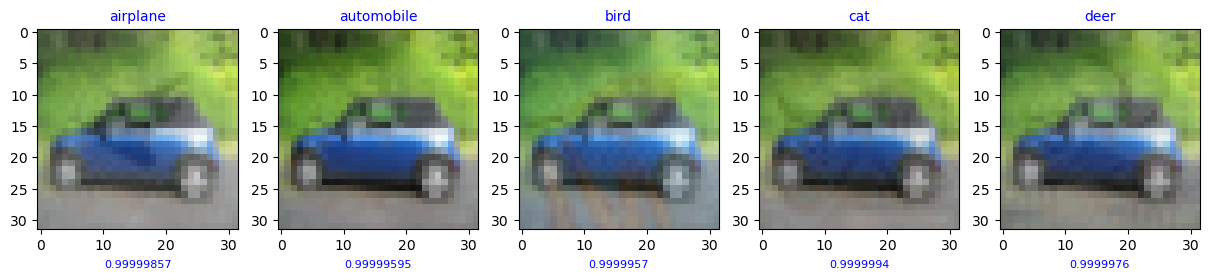

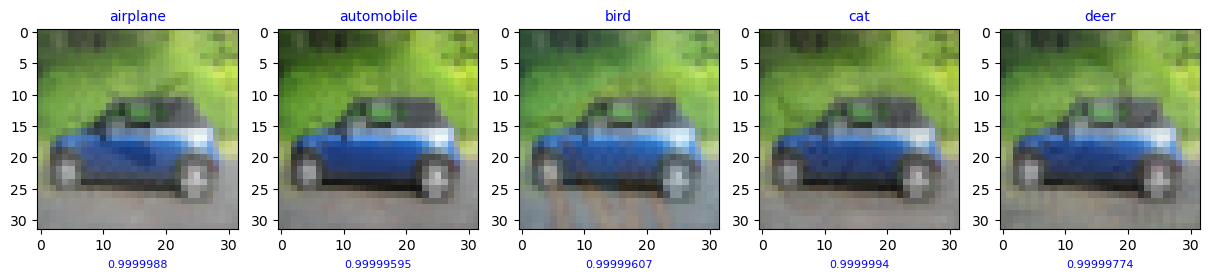

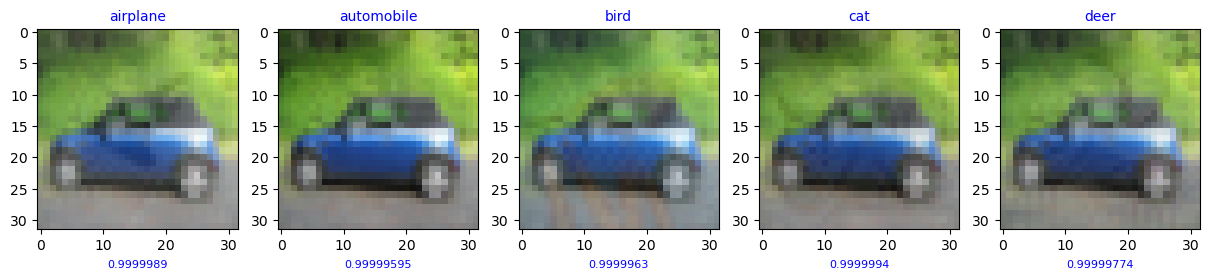

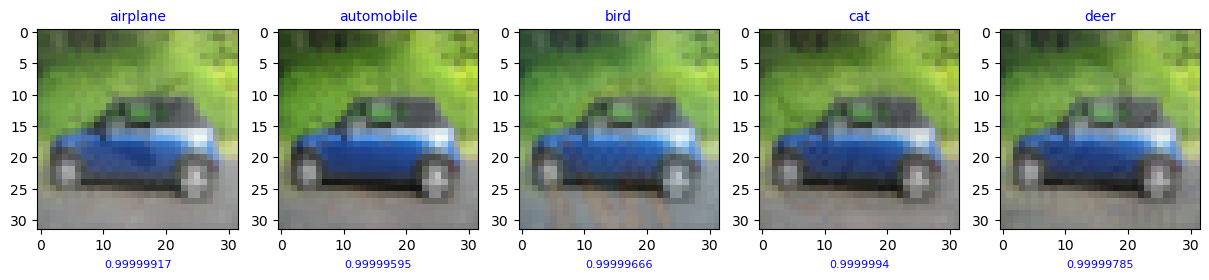

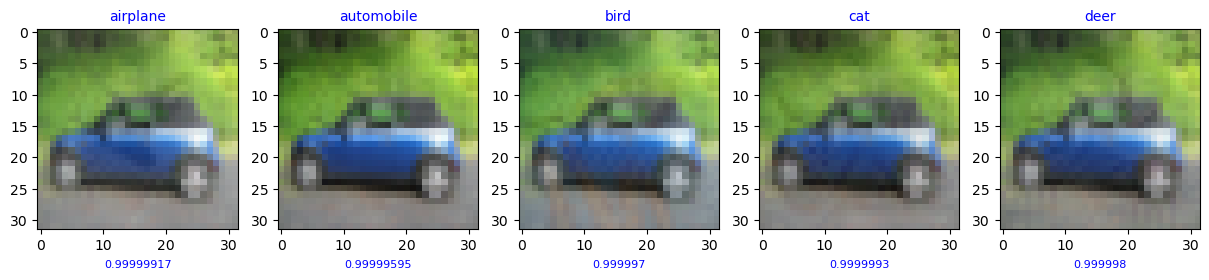

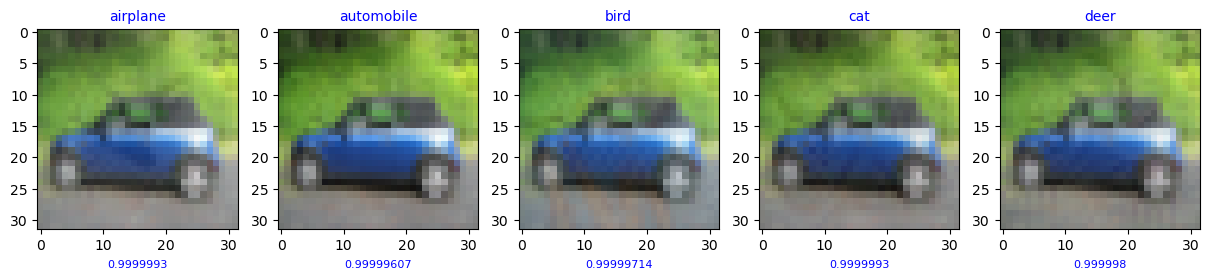

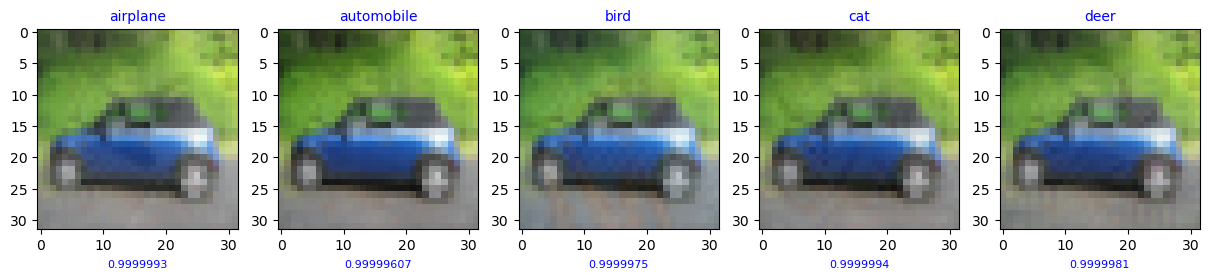

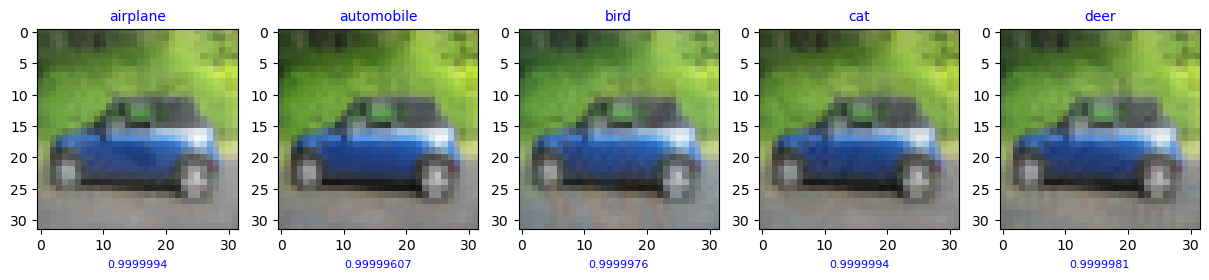

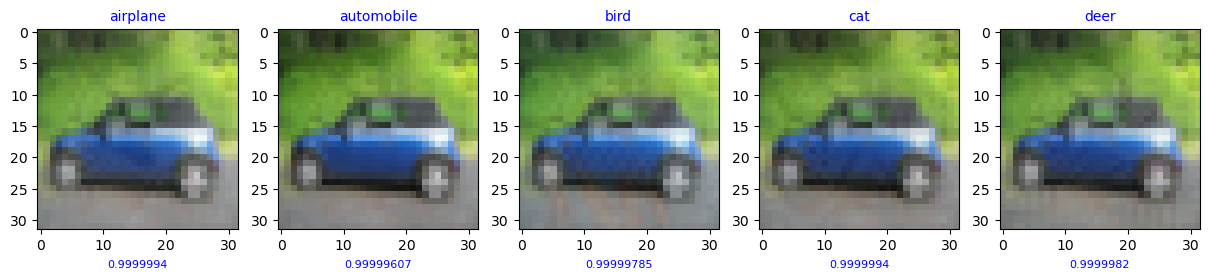

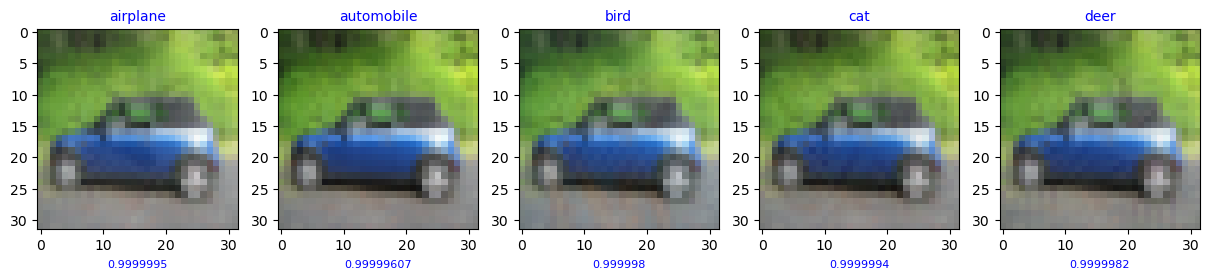

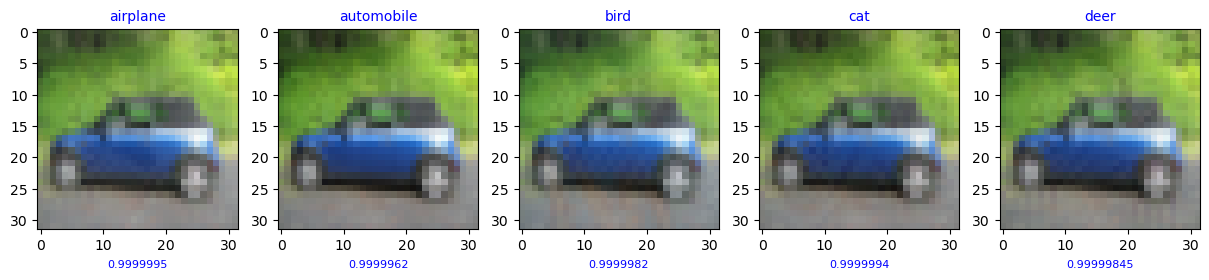

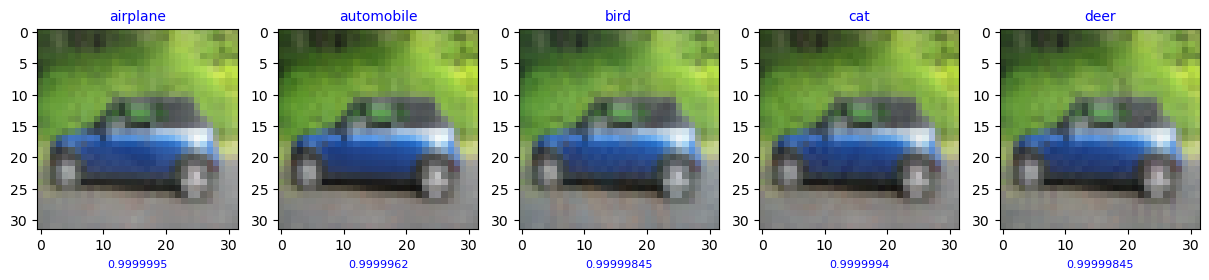

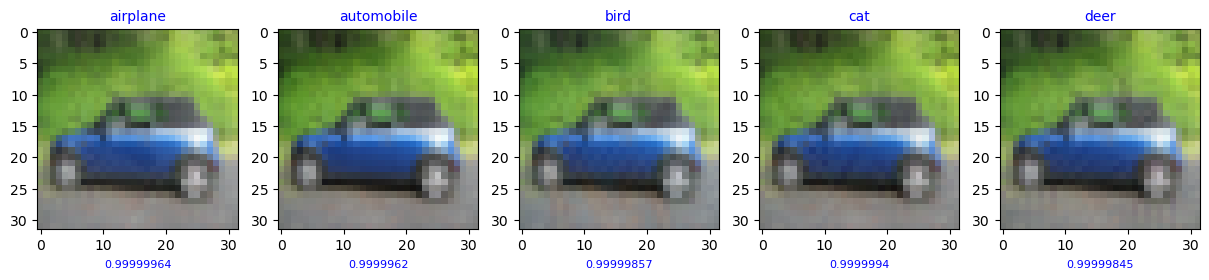

100%|██████████| 1/1 [00:34<00:00, 34.50s/it]


2


  0%|          | 0/1 [00:00<?, ?it/s]

Started


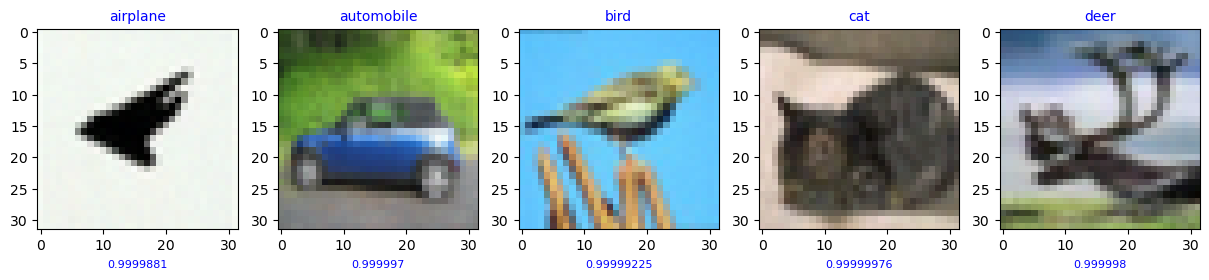

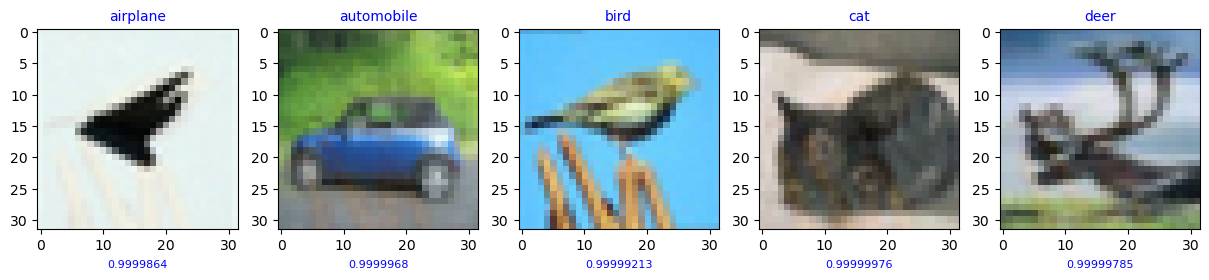

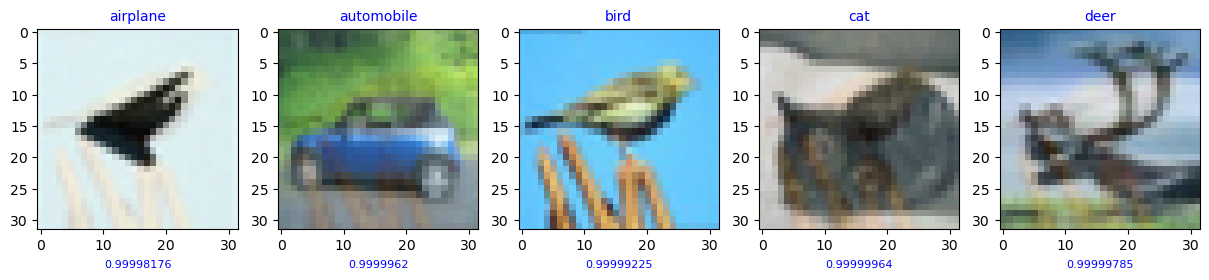

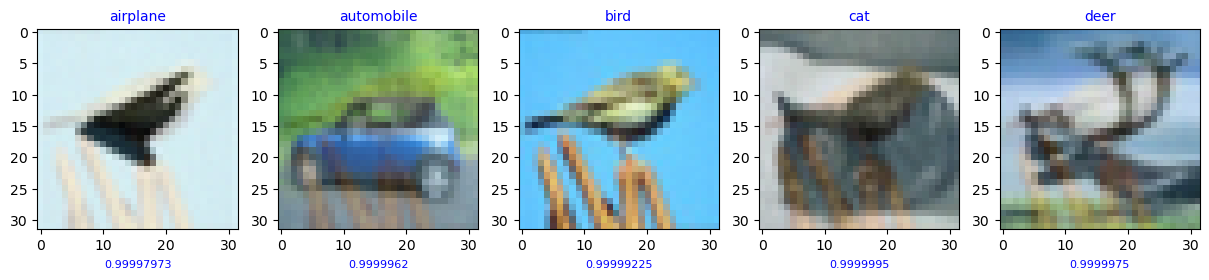

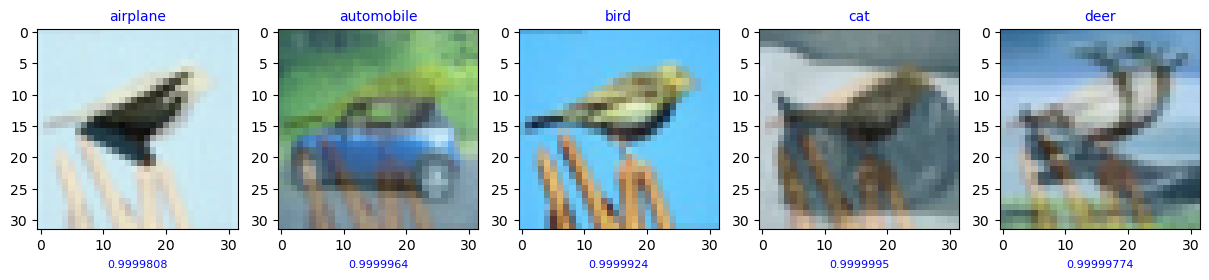

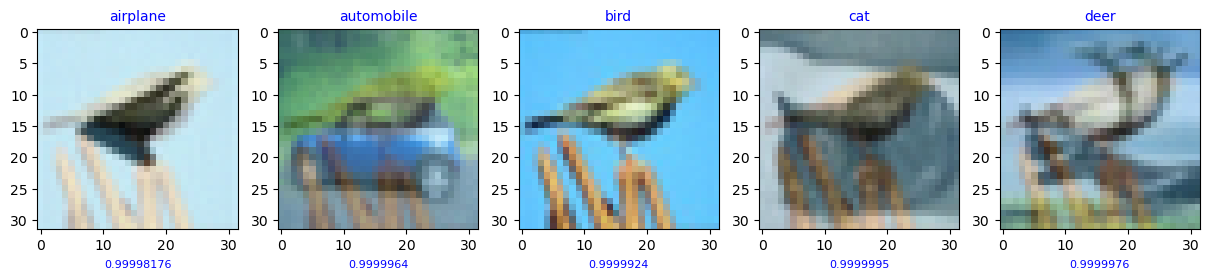

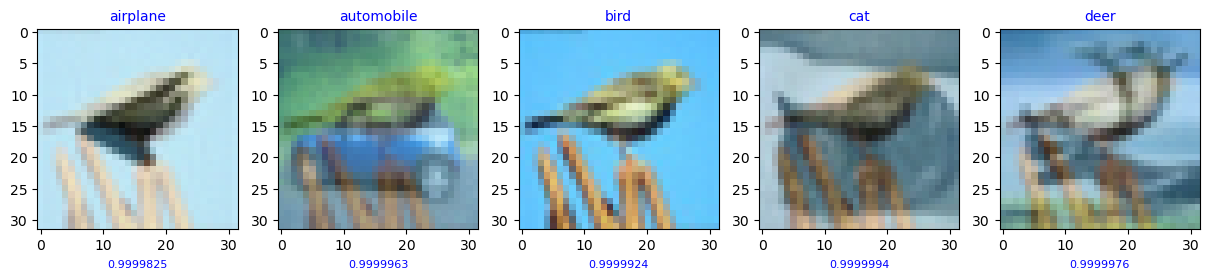

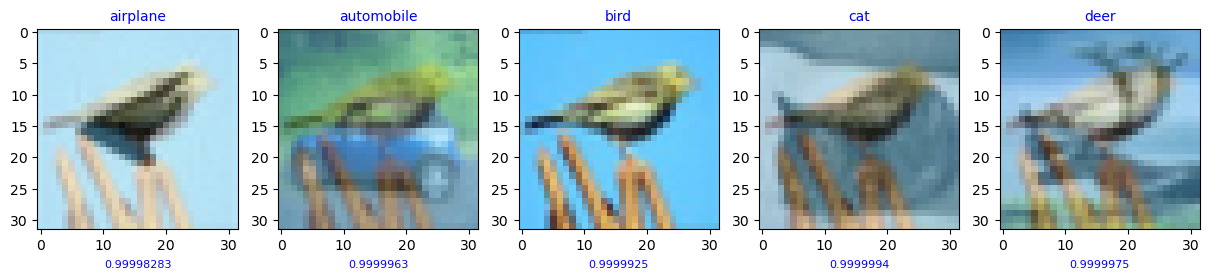

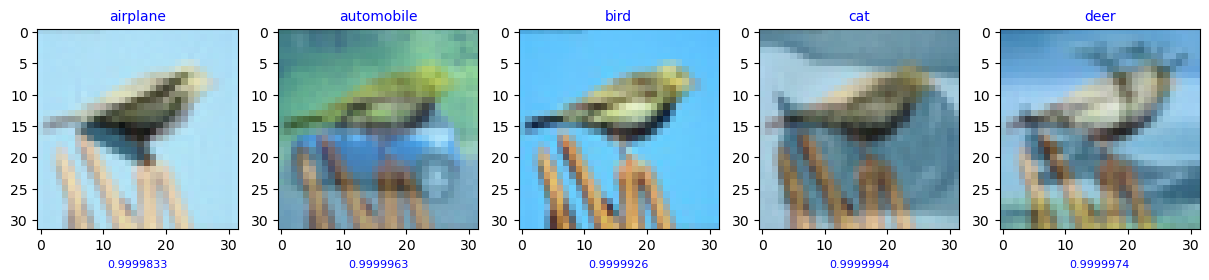

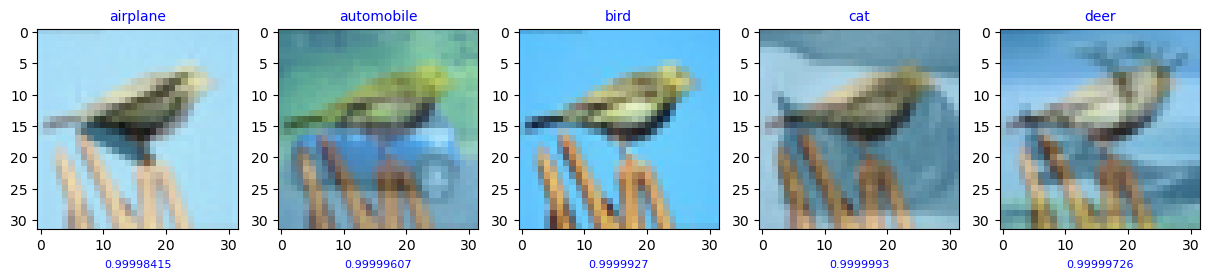

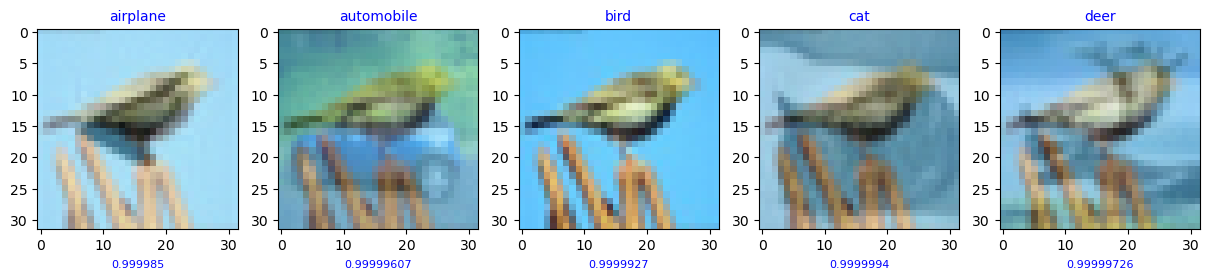

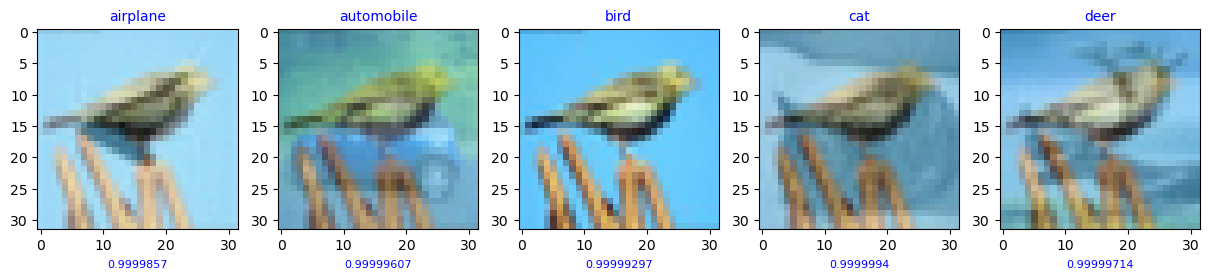

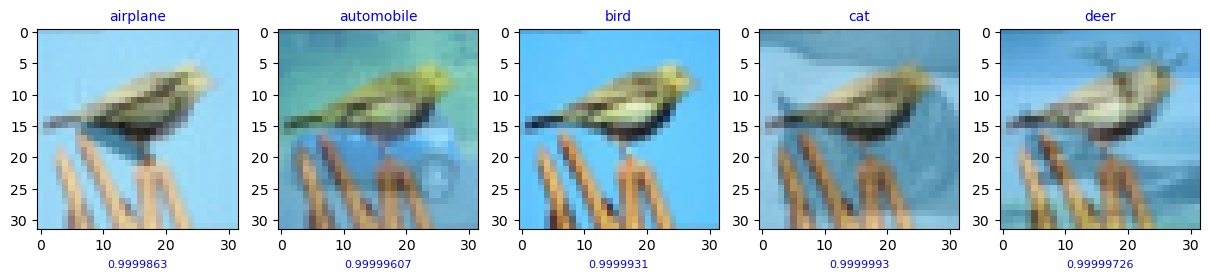

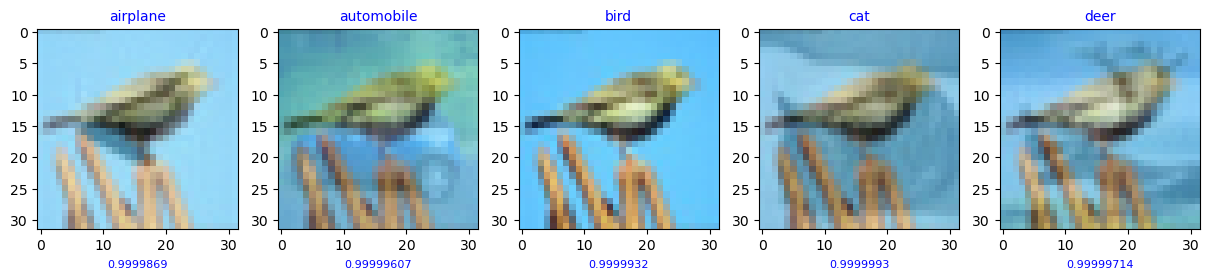

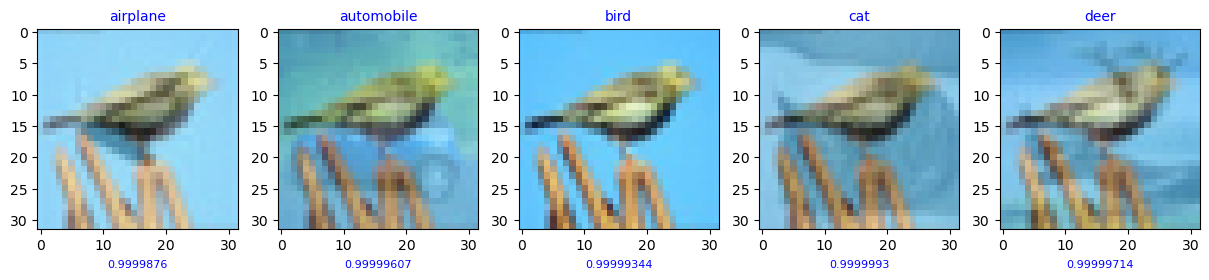

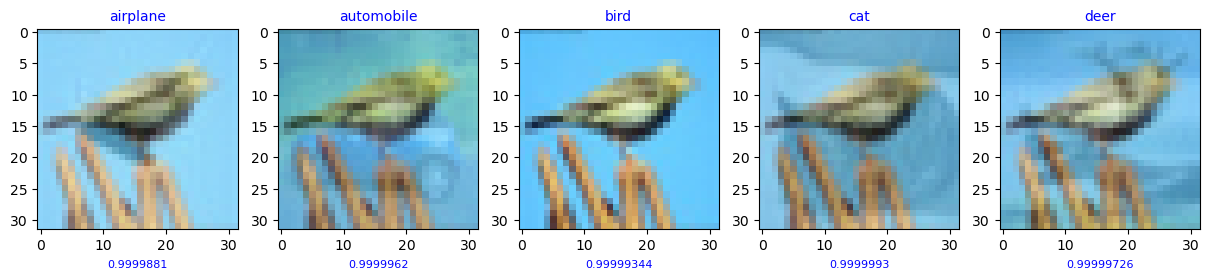

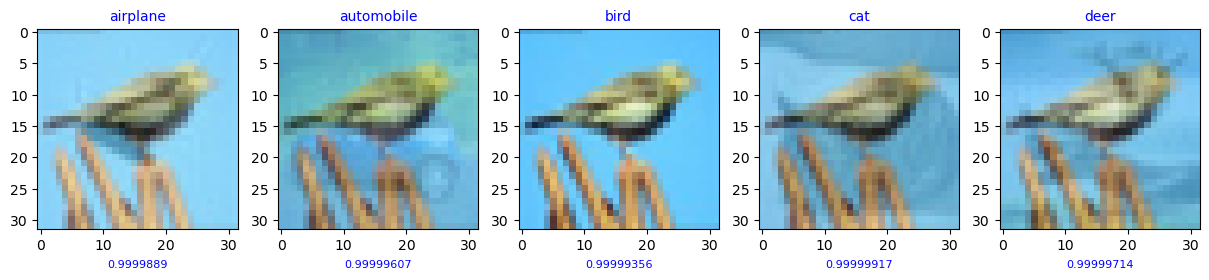

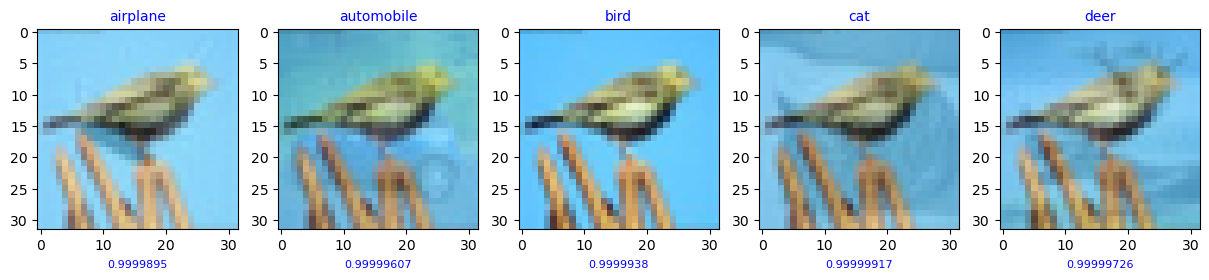

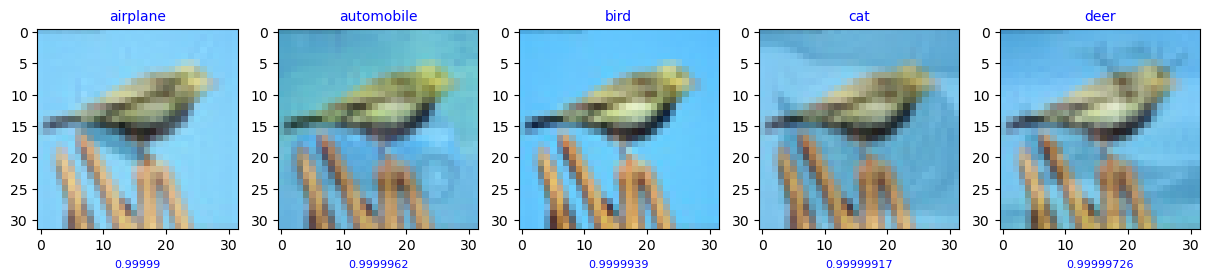

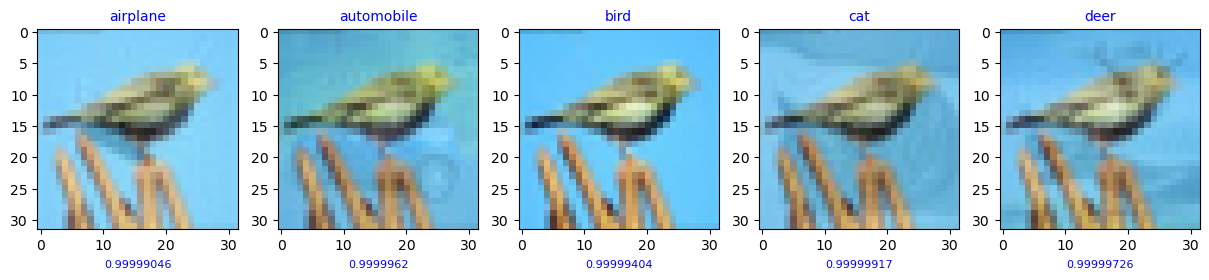

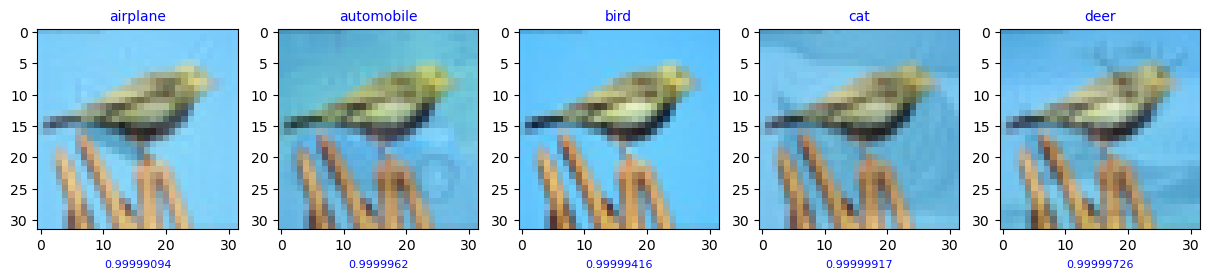

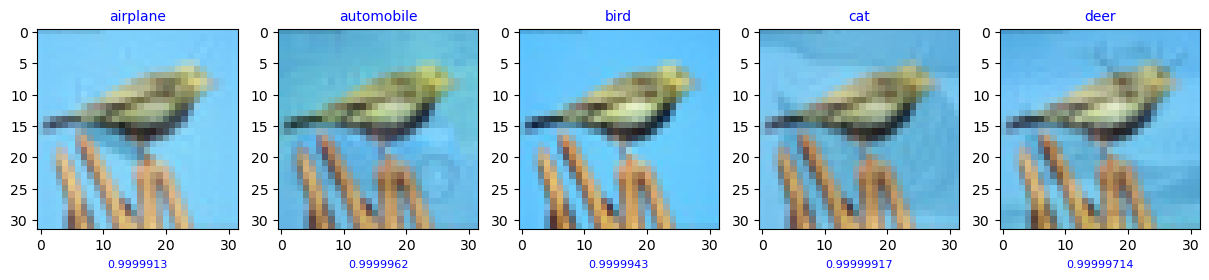

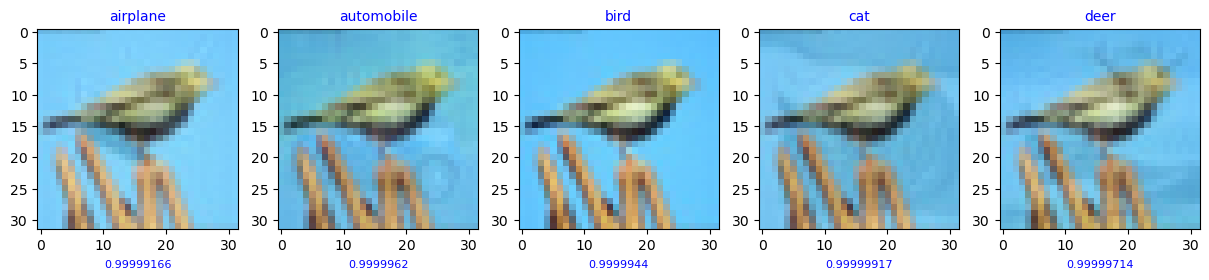

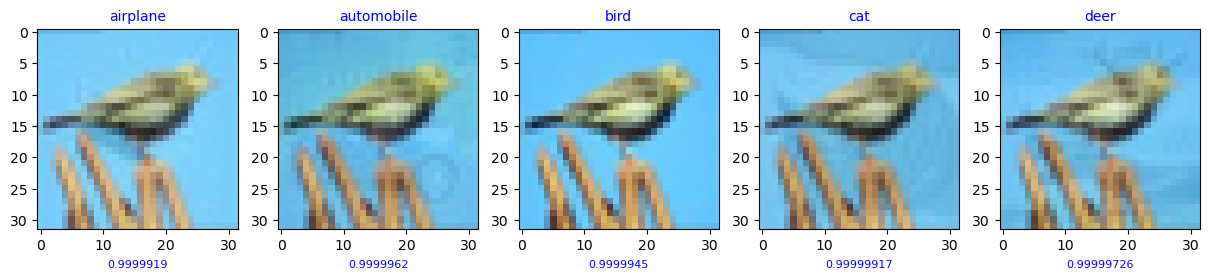

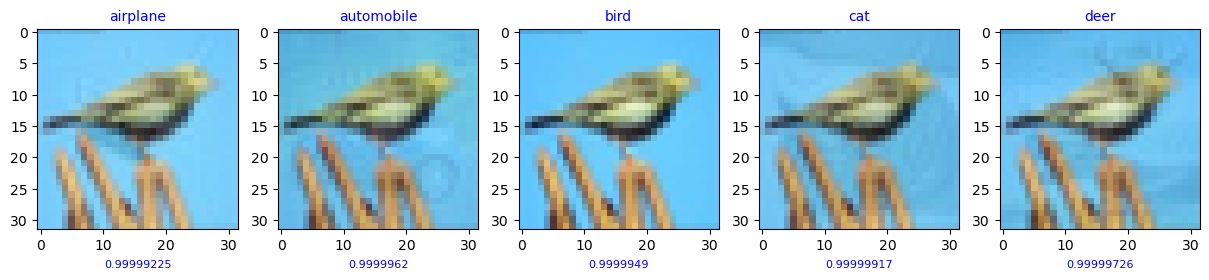

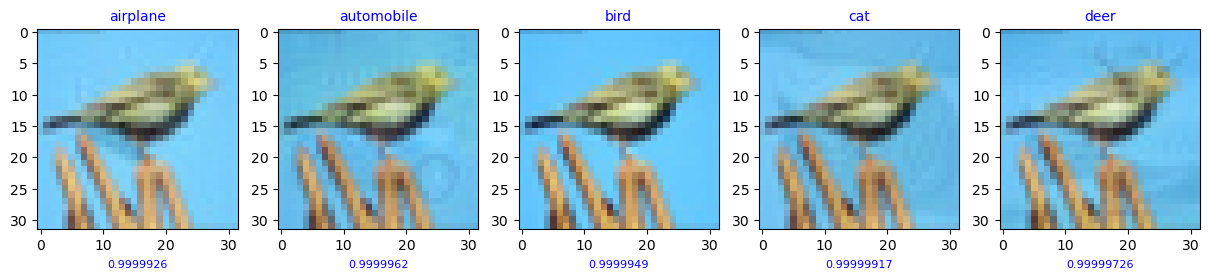

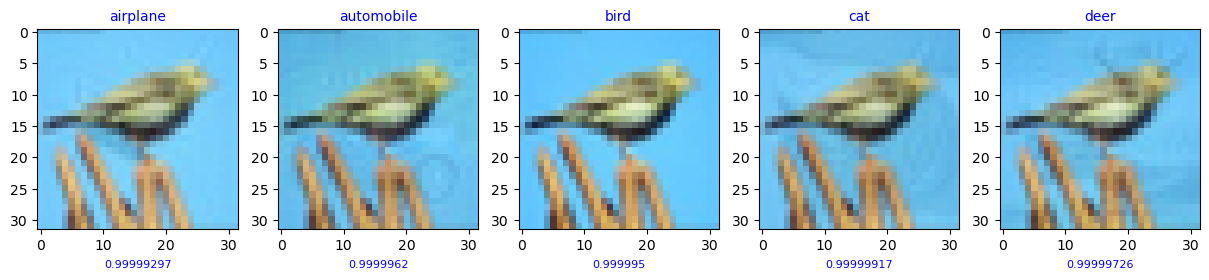

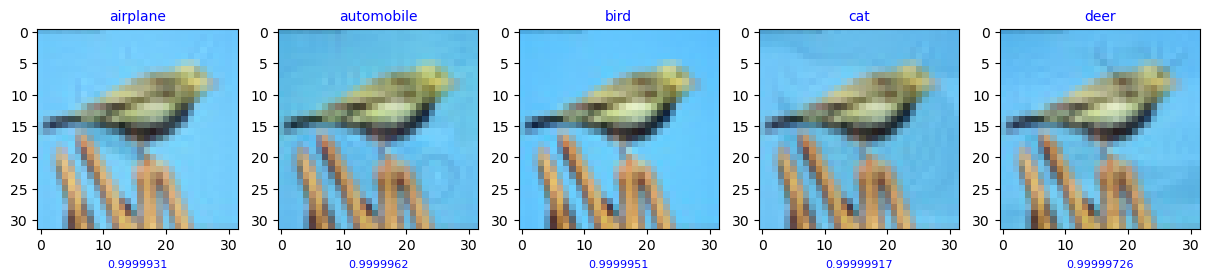

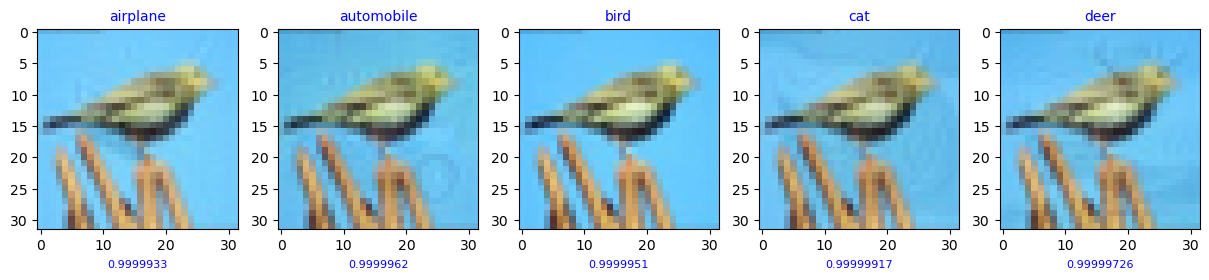

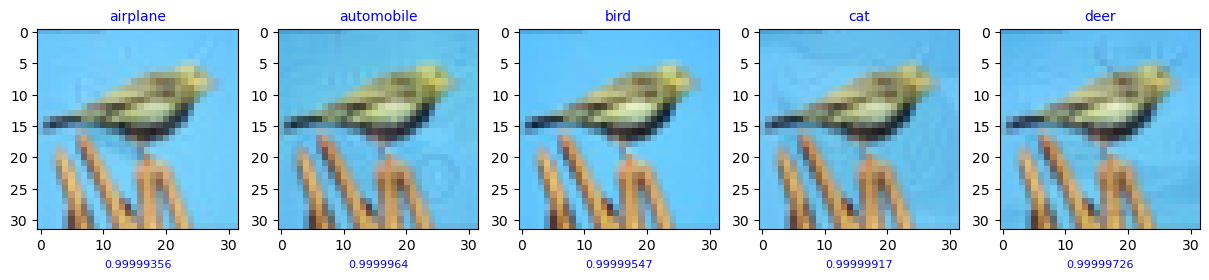

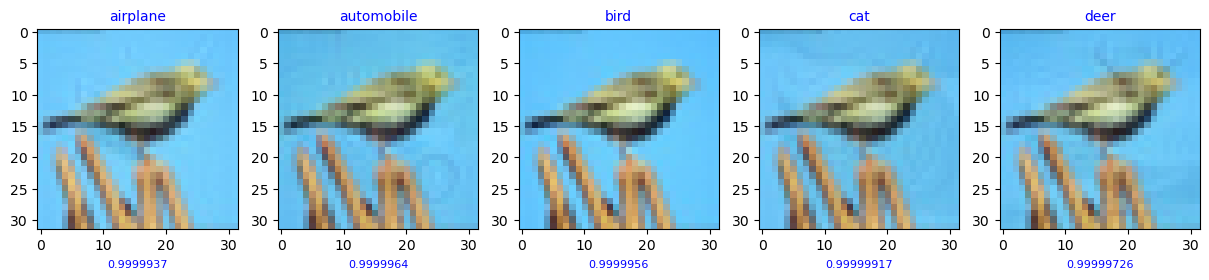

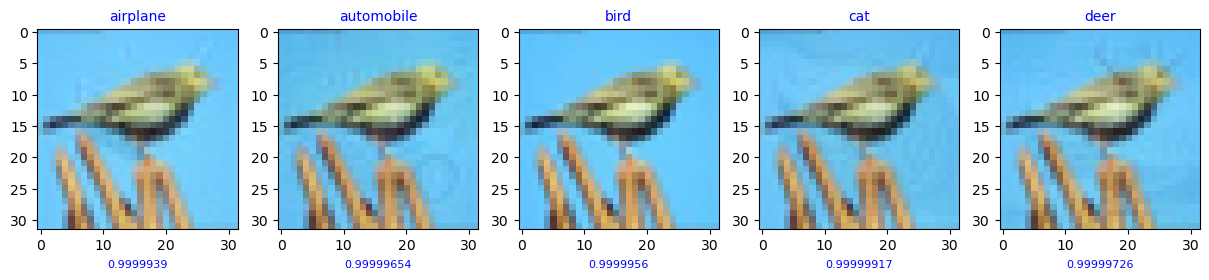

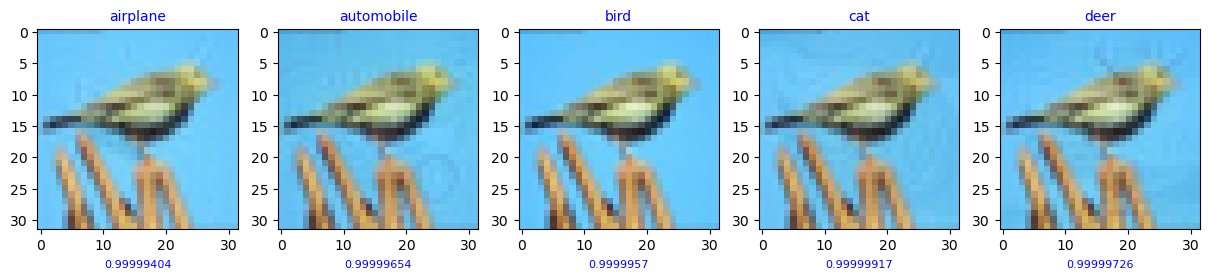

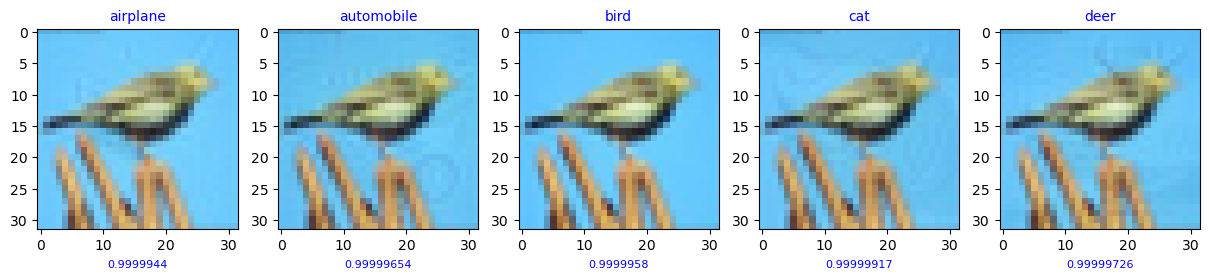

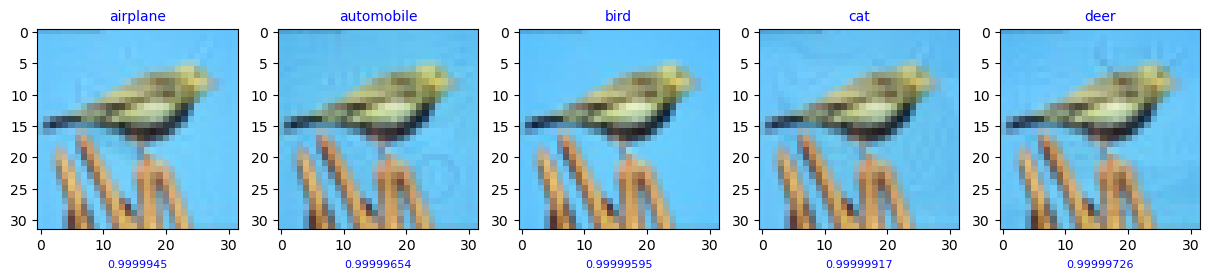

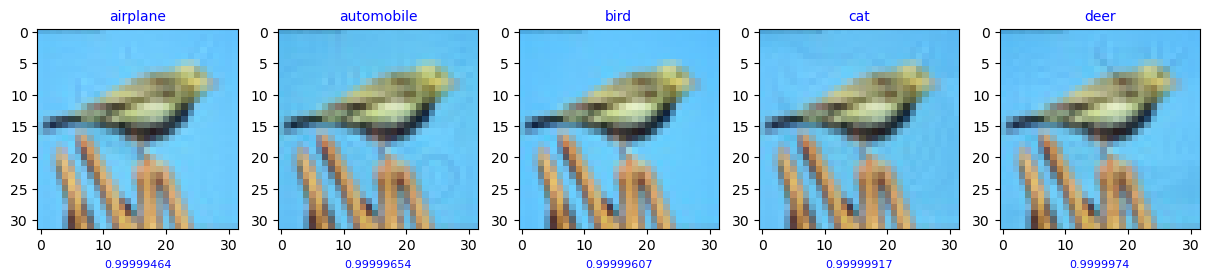

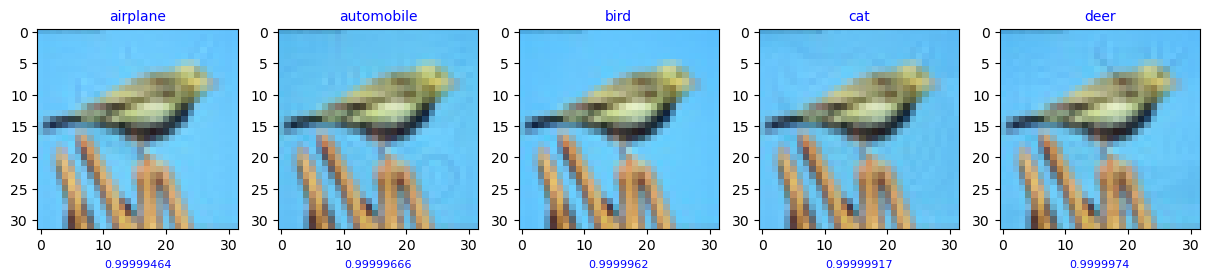

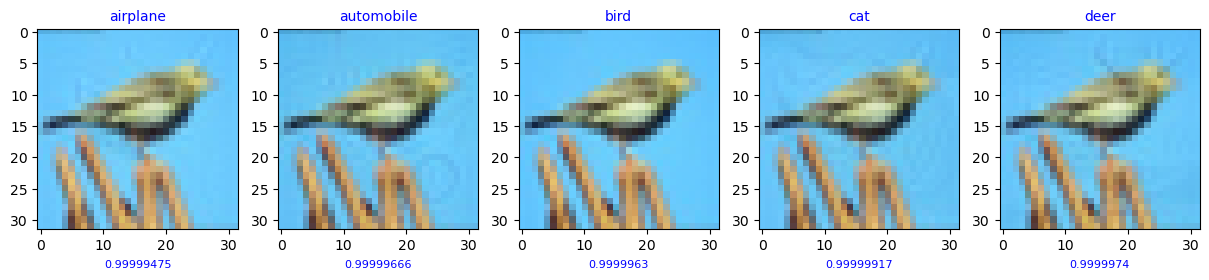

100%|██████████| 1/1 [00:35<00:00, 35.05s/it]


3


  0%|          | 0/1 [00:00<?, ?it/s]

Started


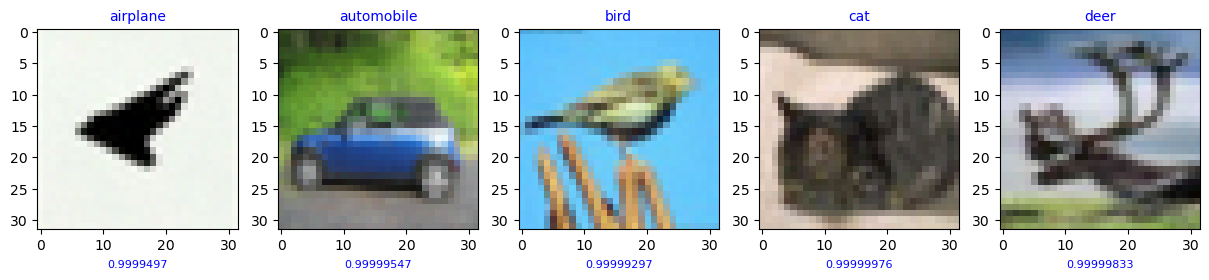

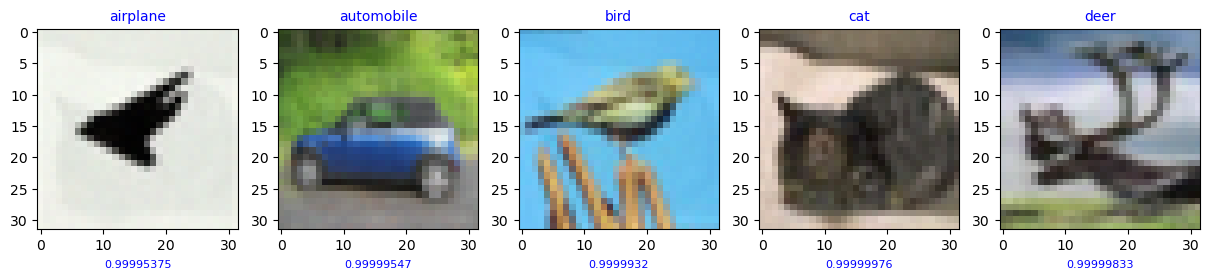

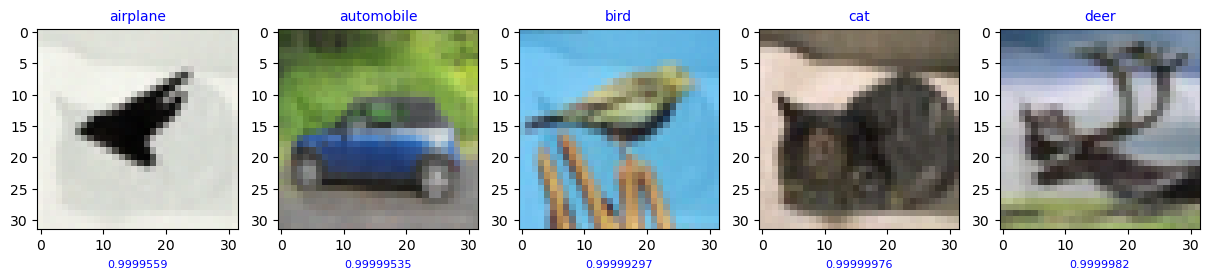

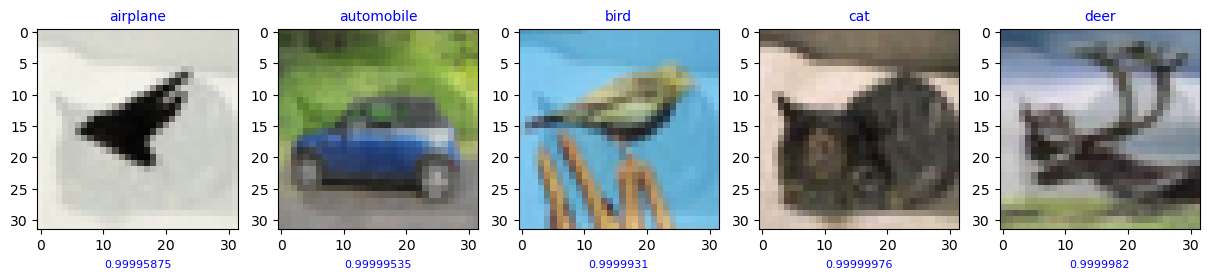

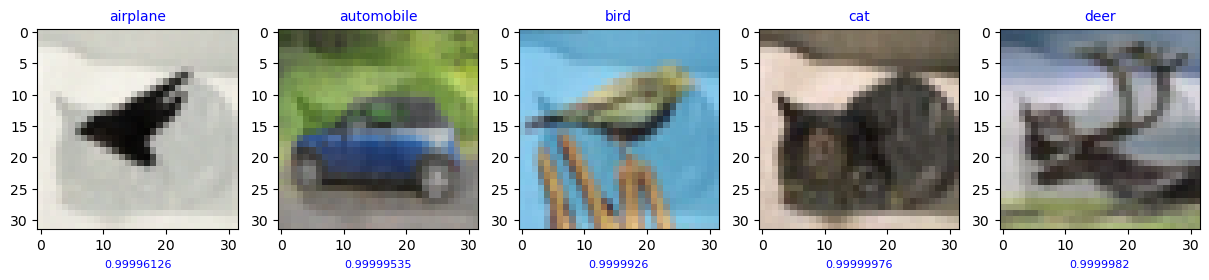

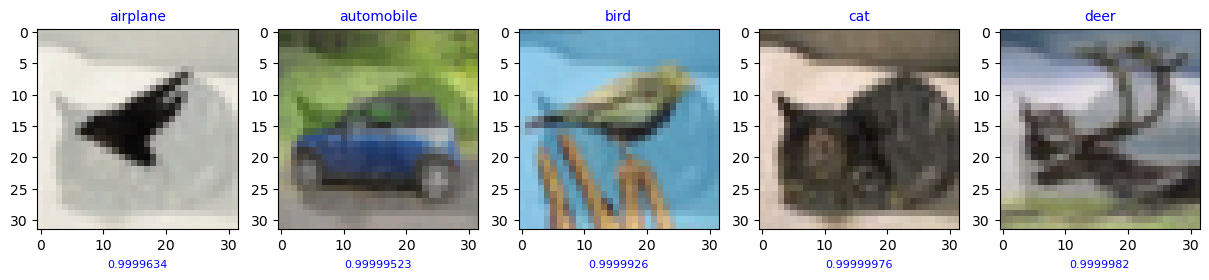

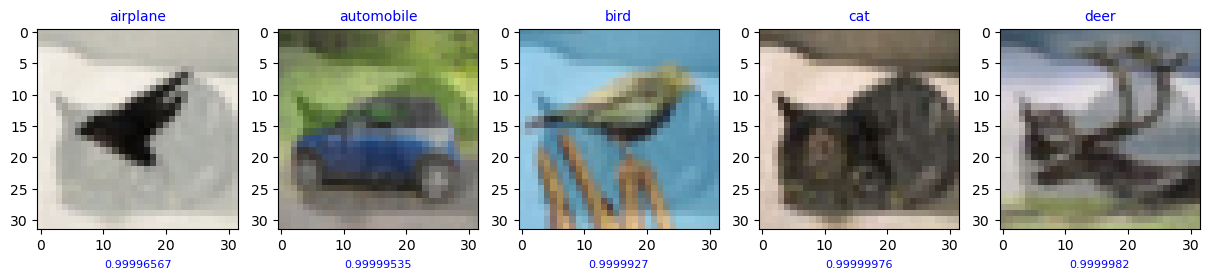

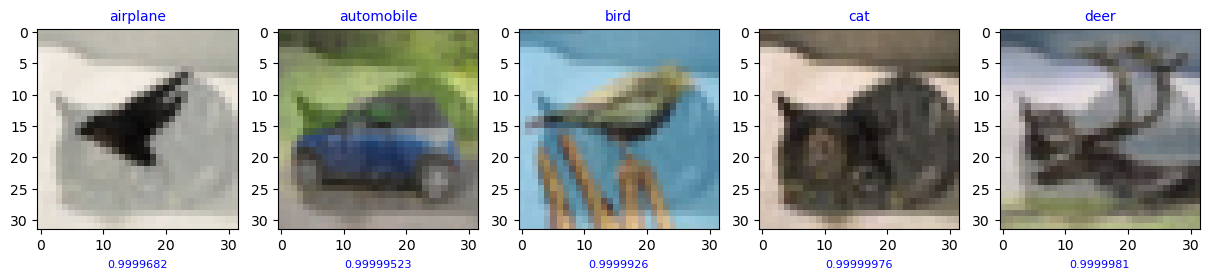

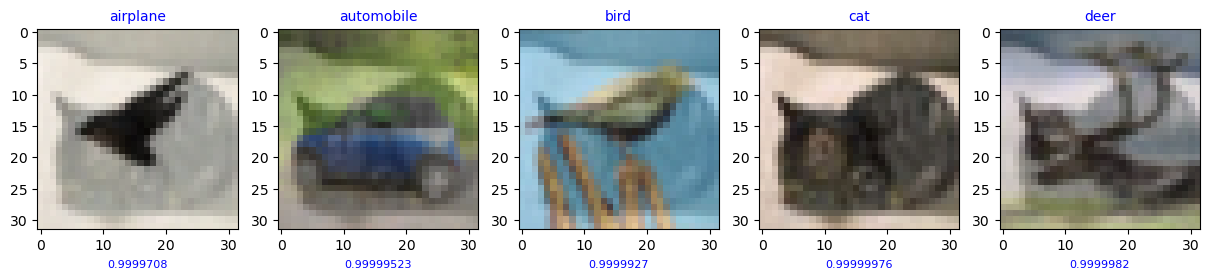

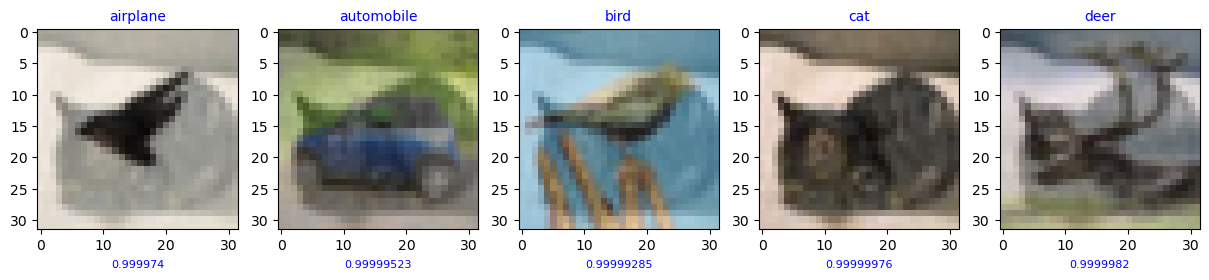

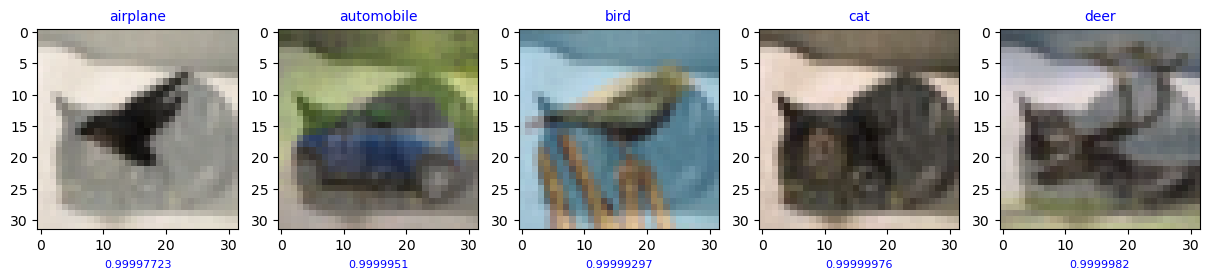

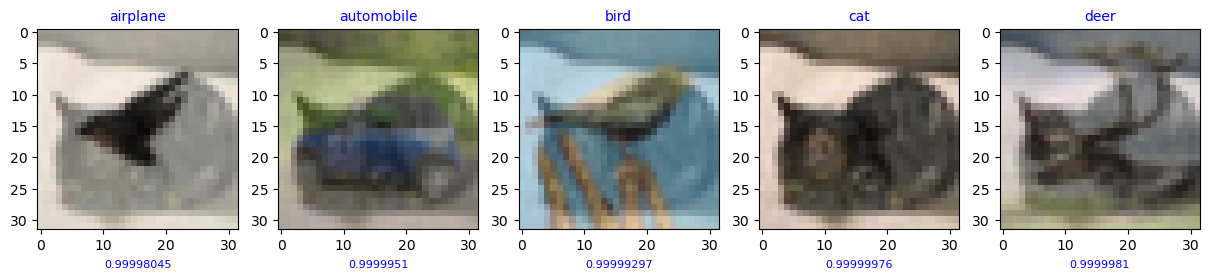

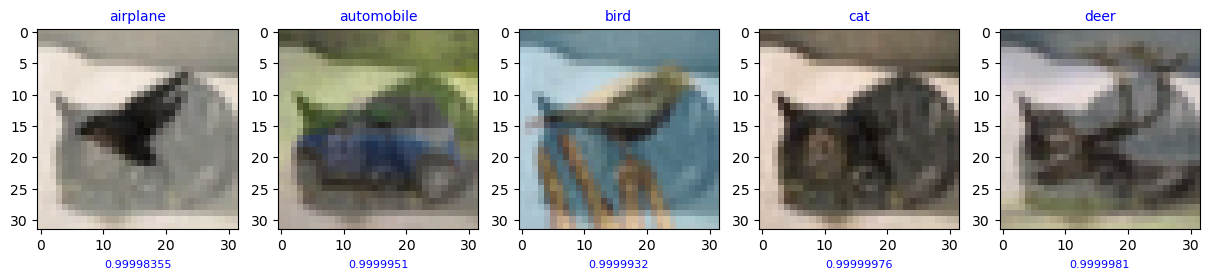

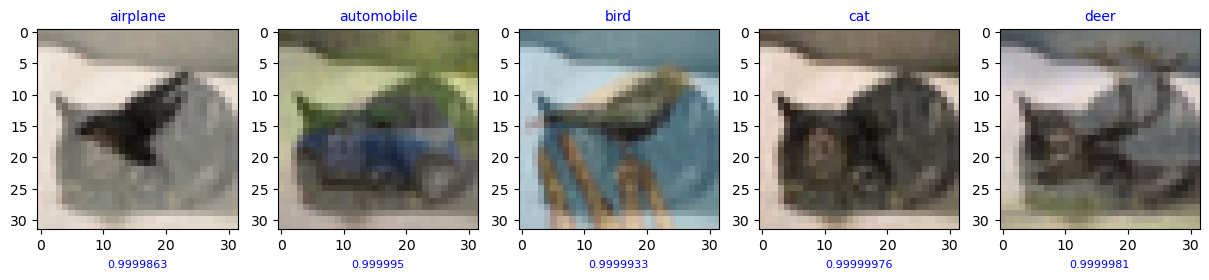

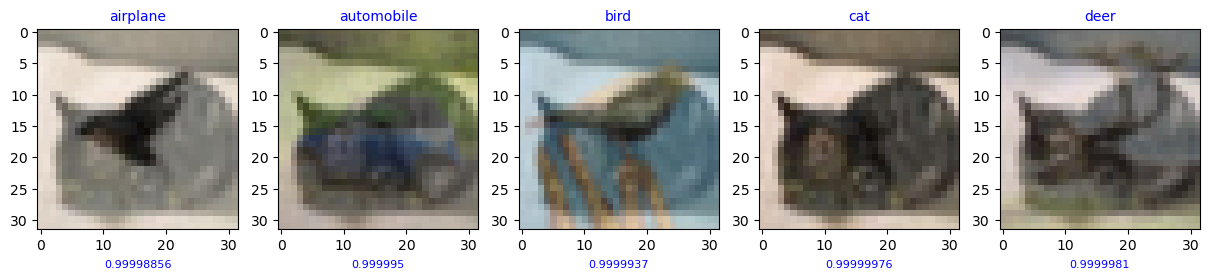

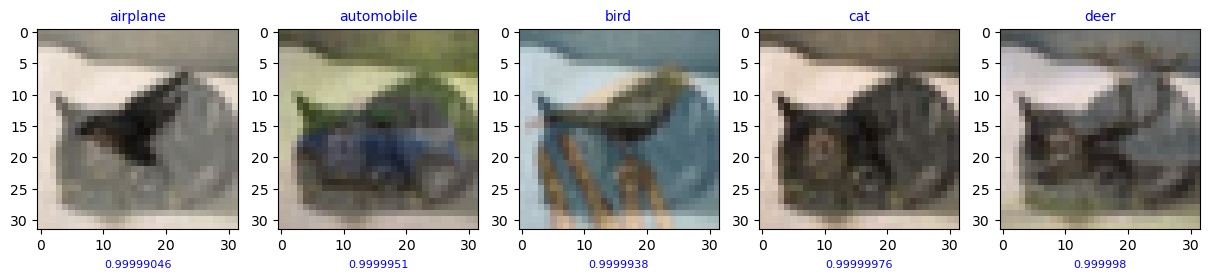

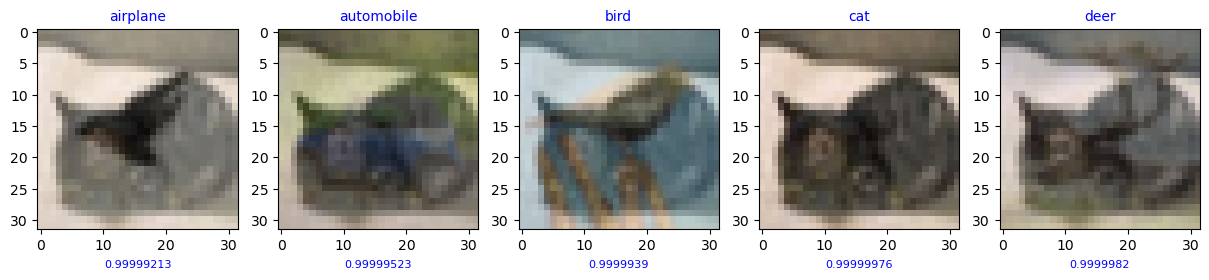

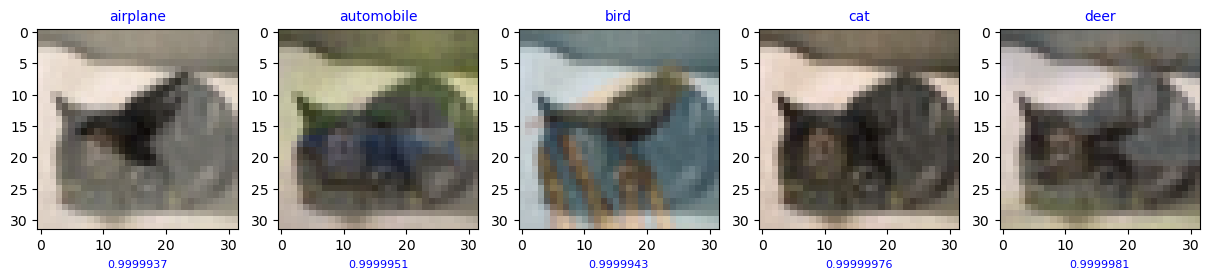

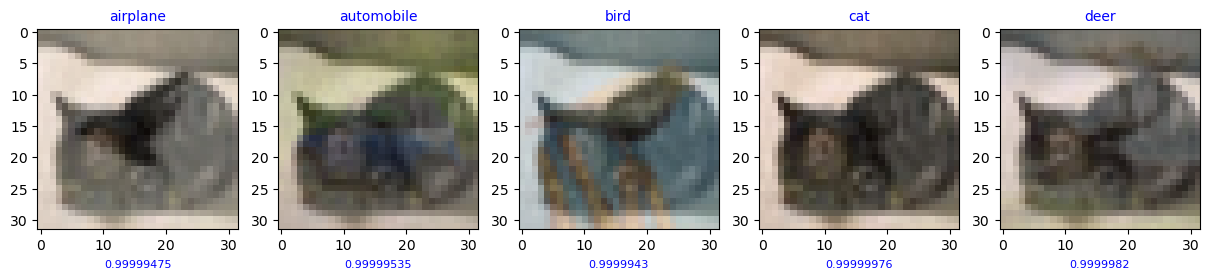

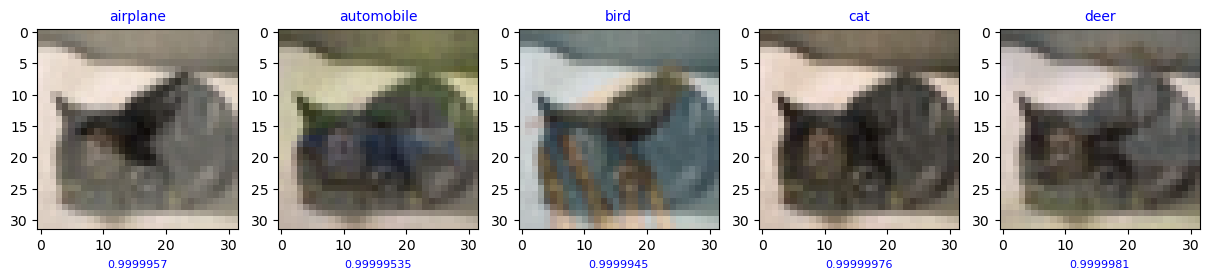

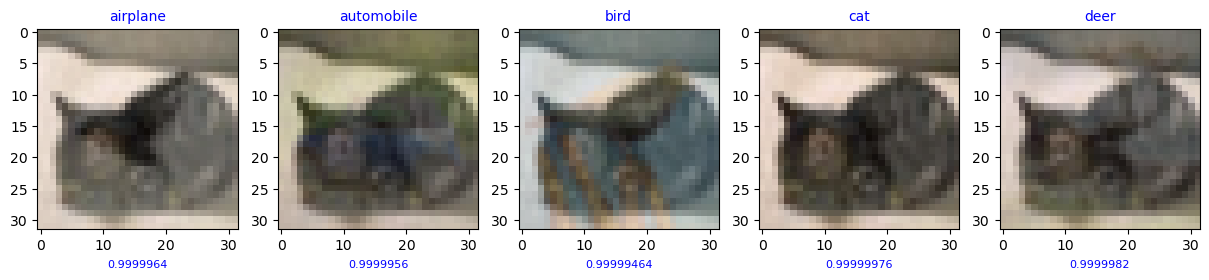

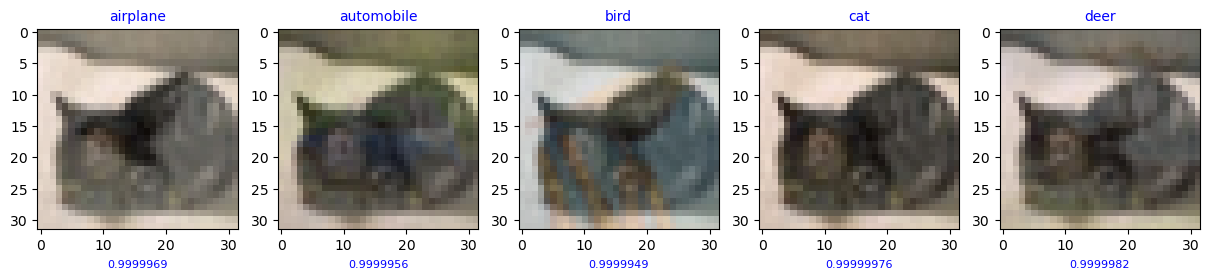

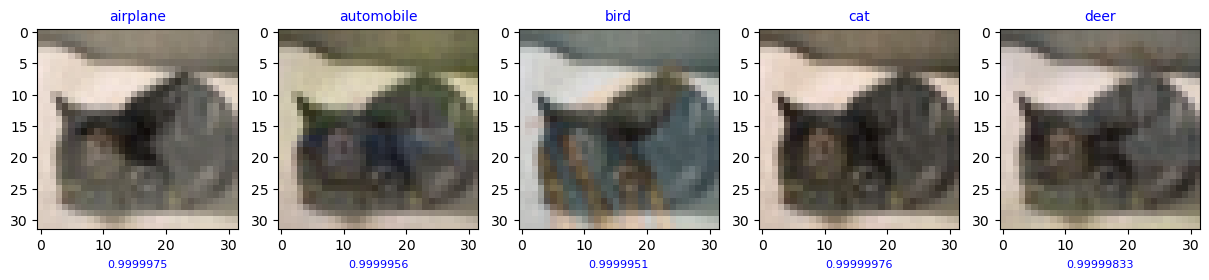

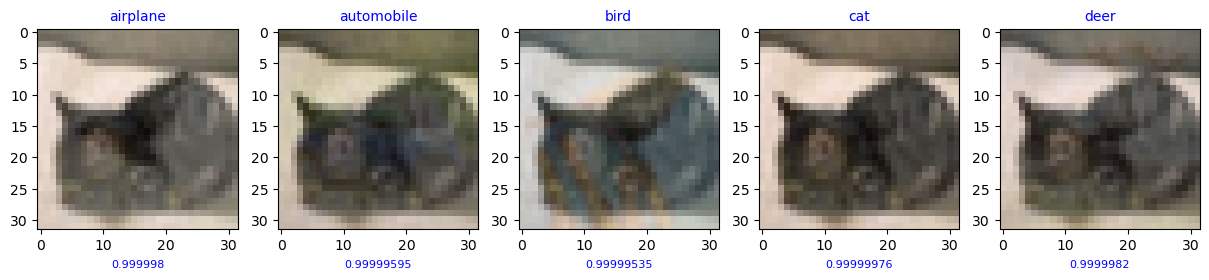

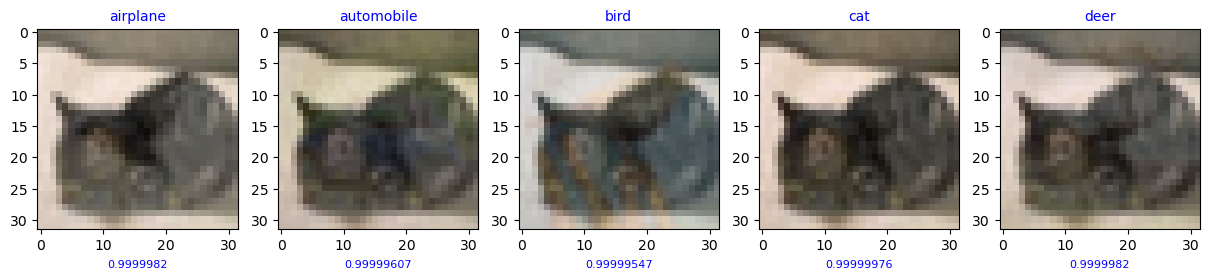

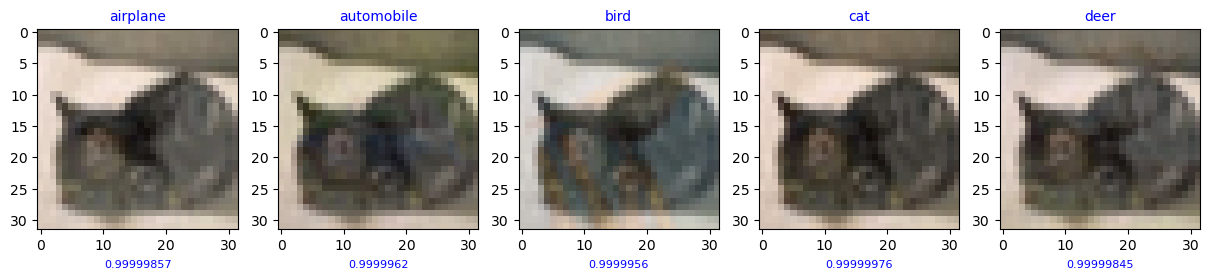

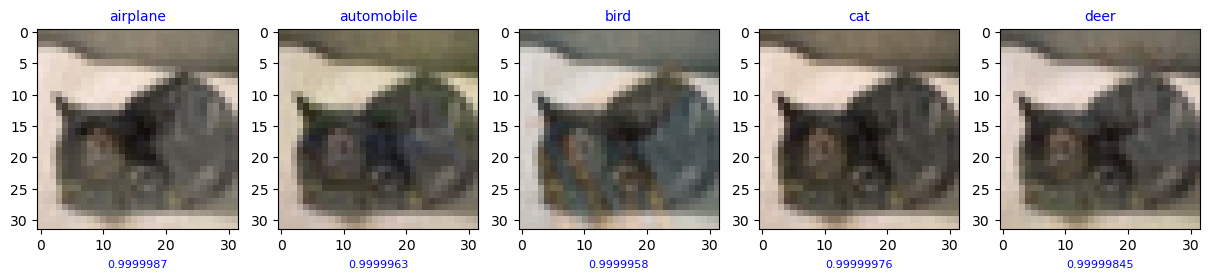

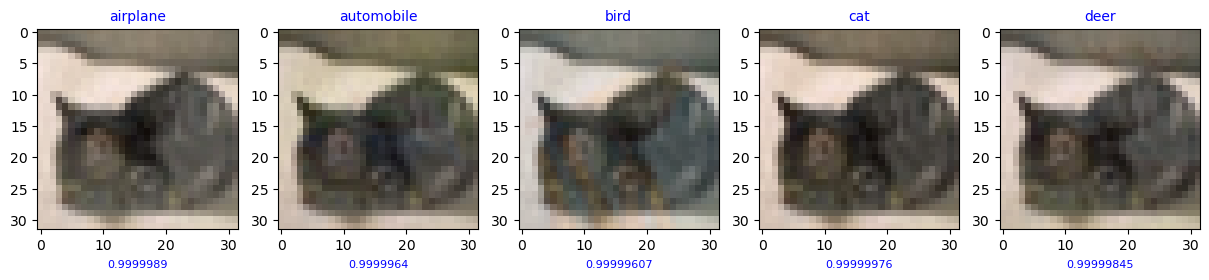

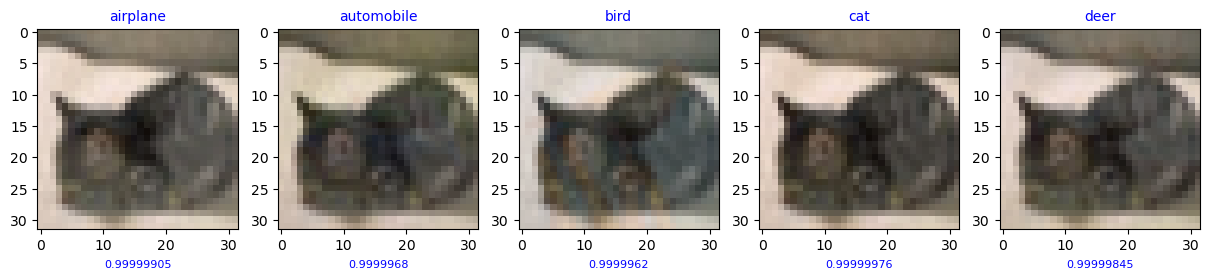

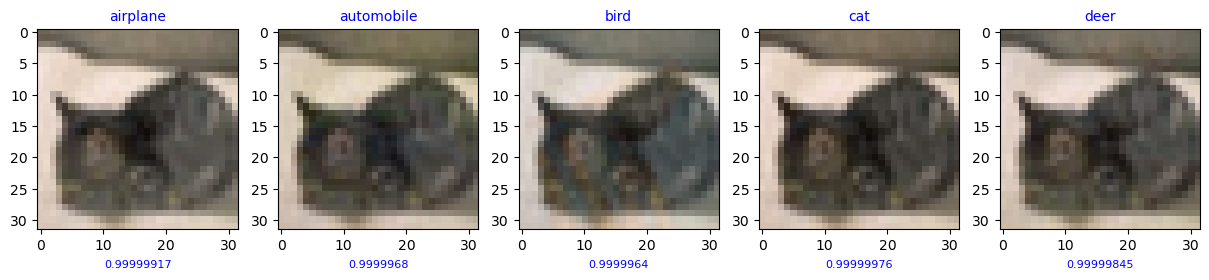

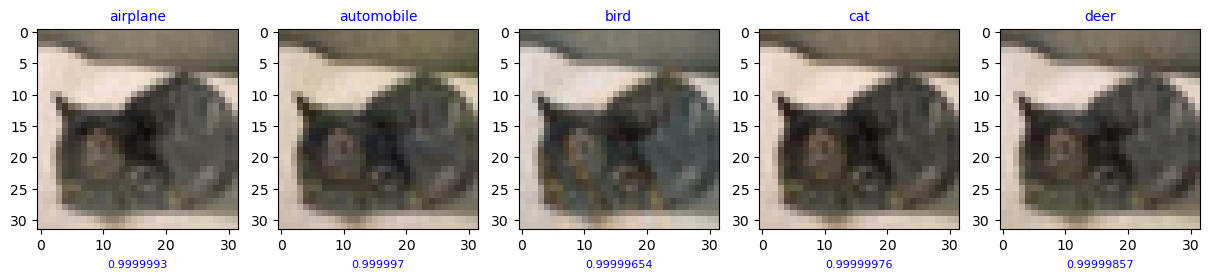

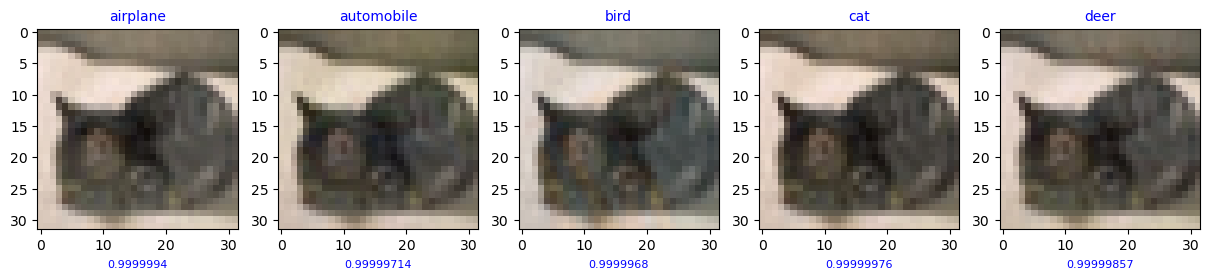

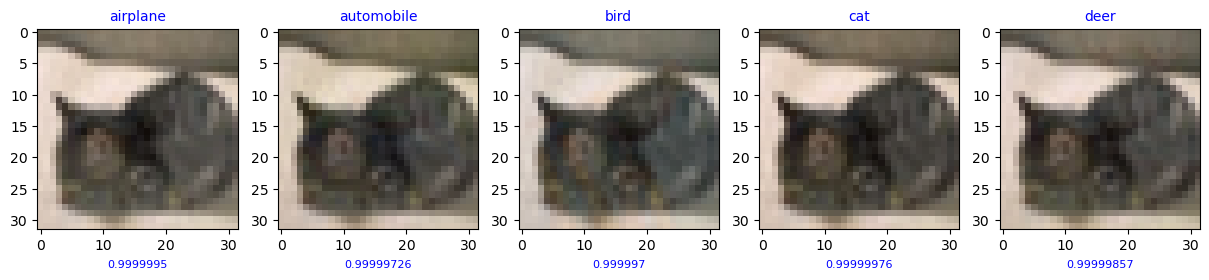

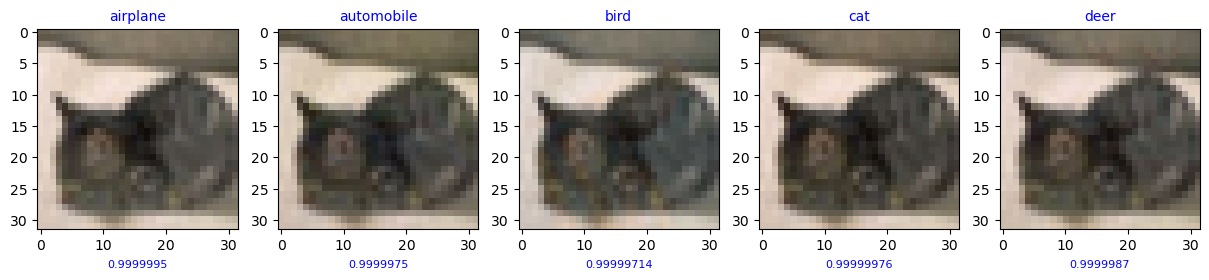

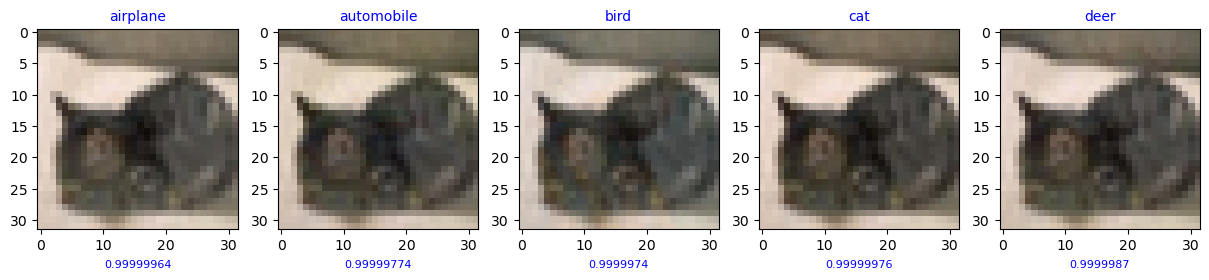

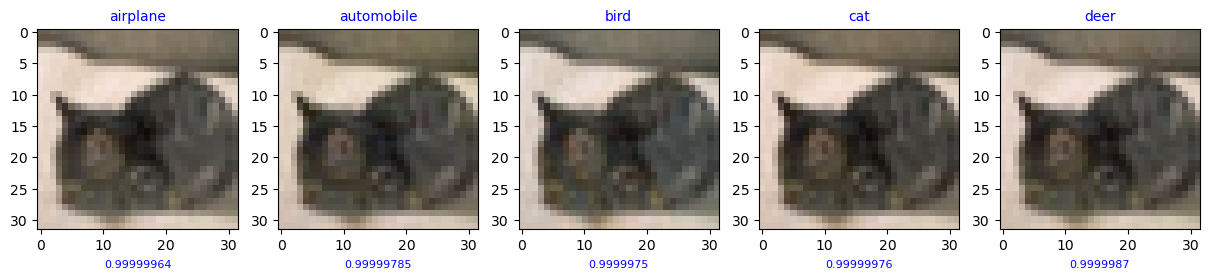

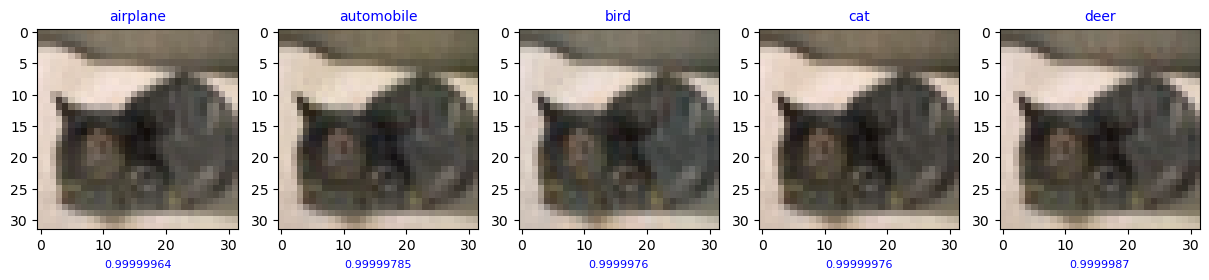

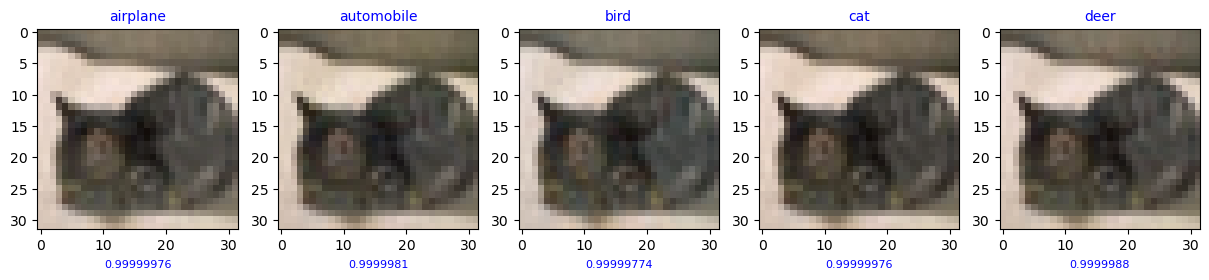

100%|██████████| 1/1 [00:34<00:00, 34.98s/it]


4


  0%|          | 0/1 [00:00<?, ?it/s]

Started


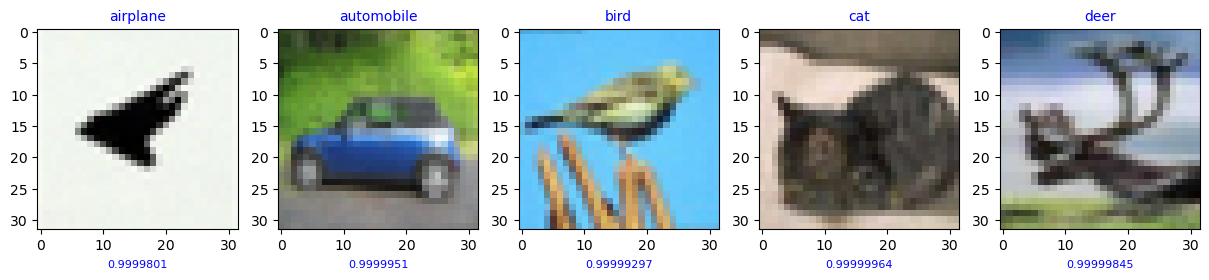

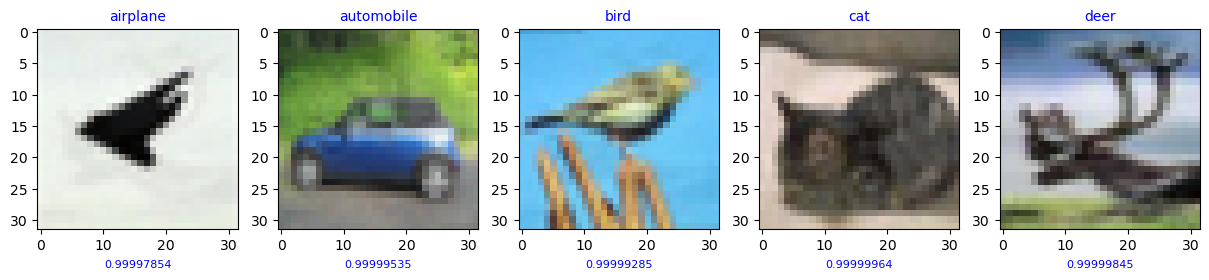

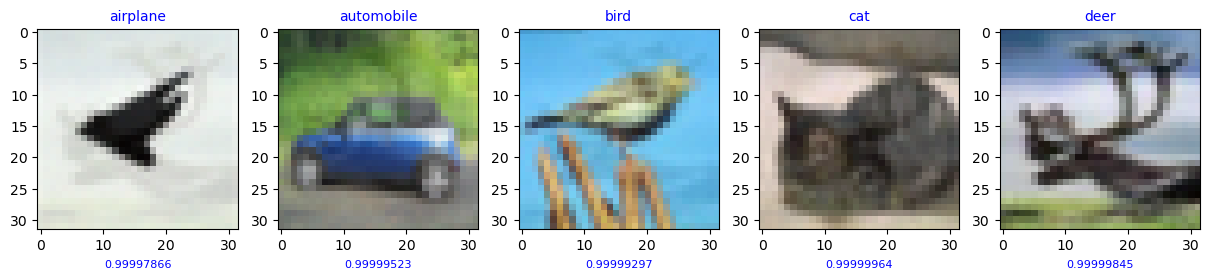

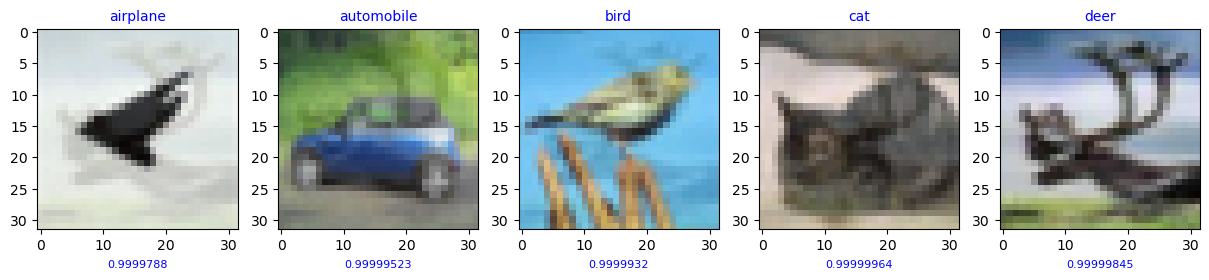

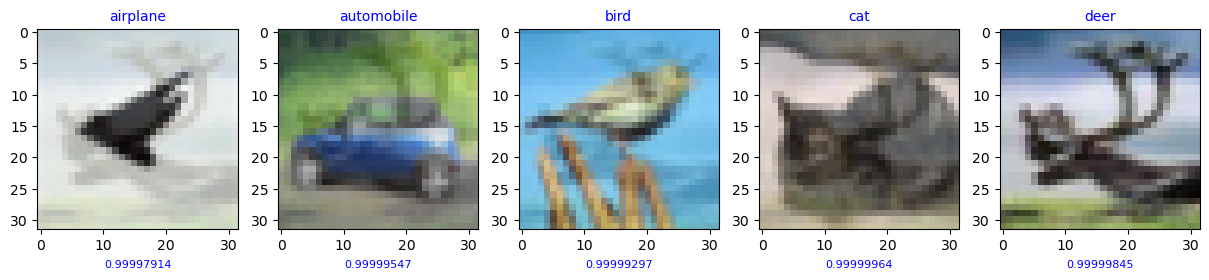

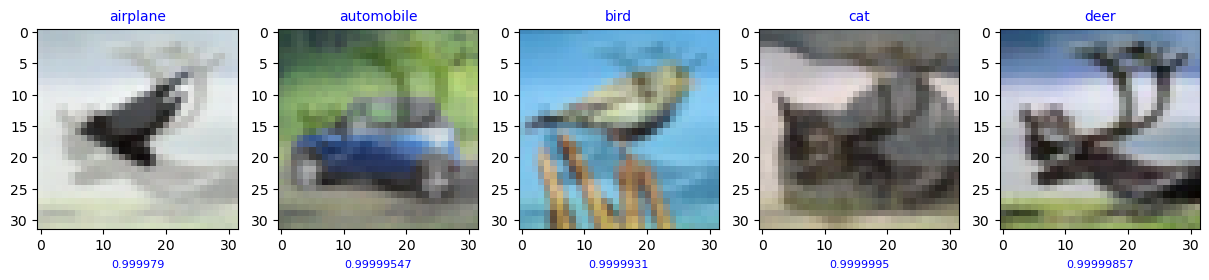

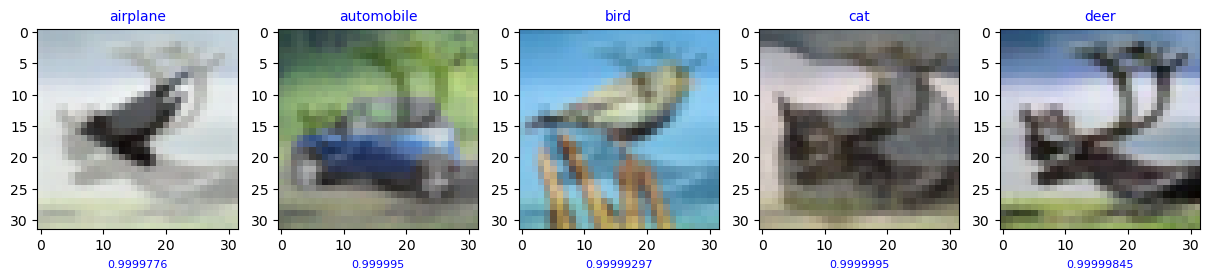

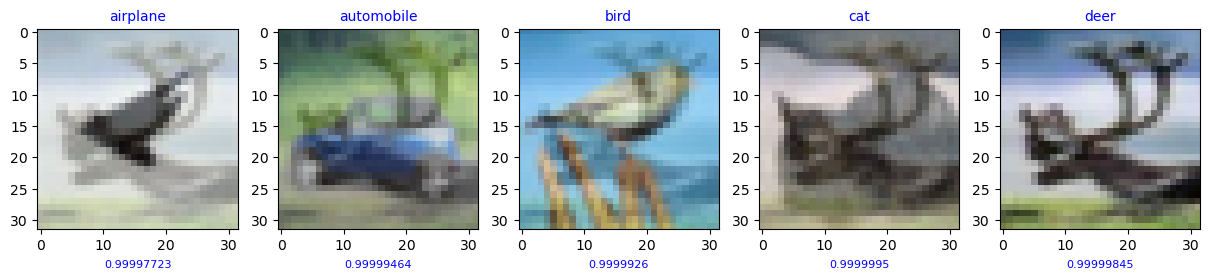

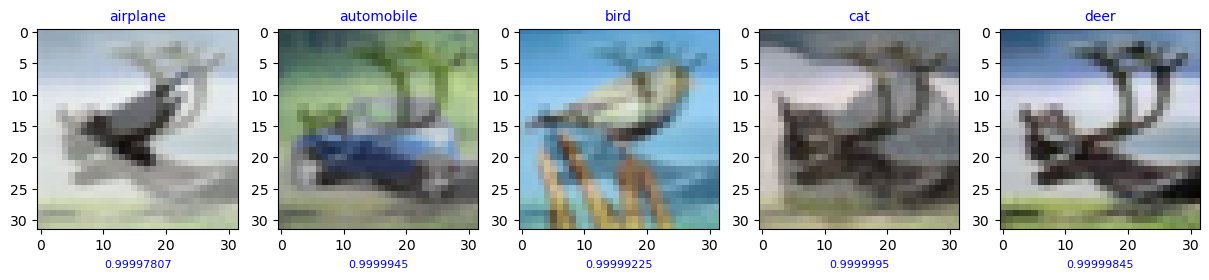

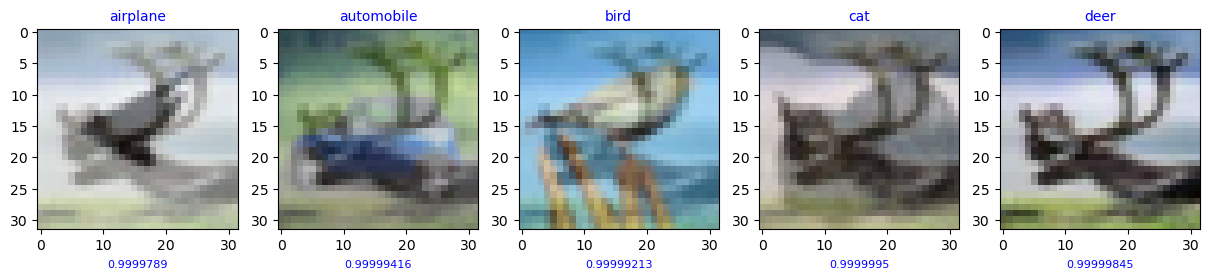

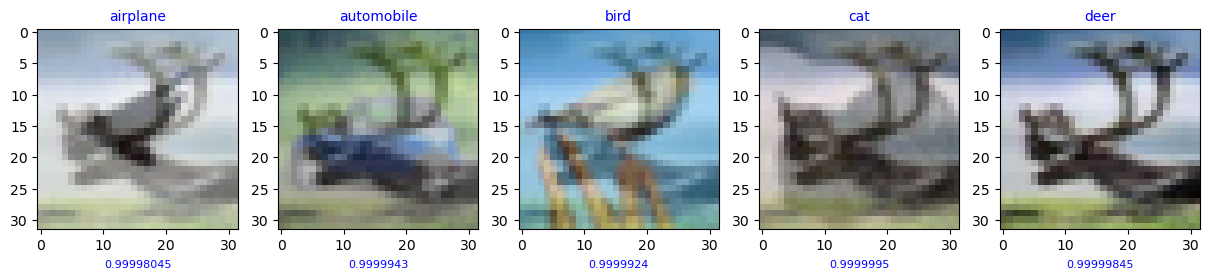

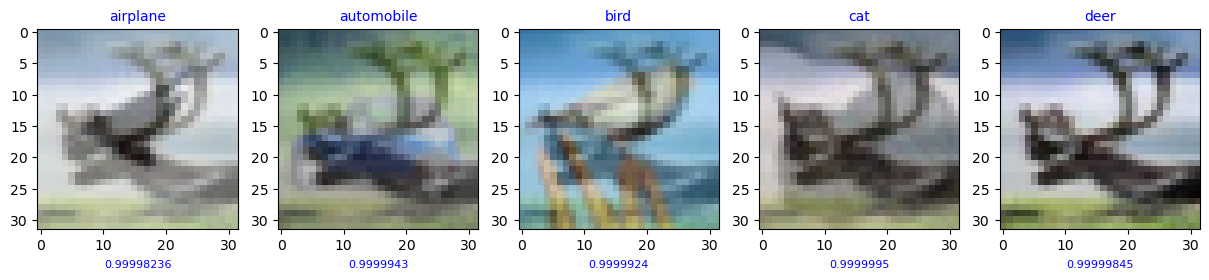

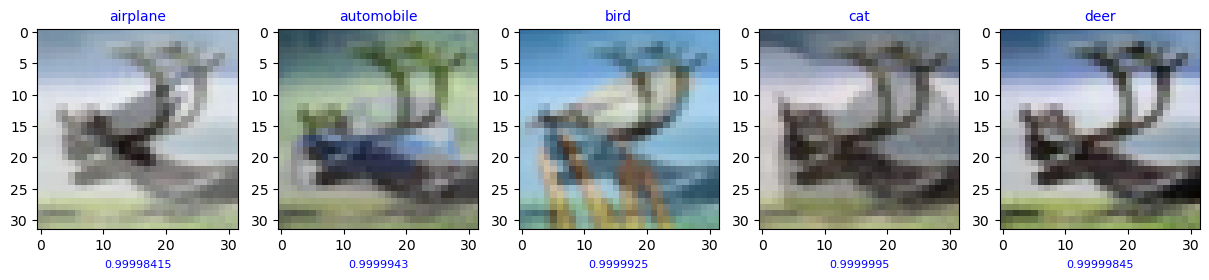

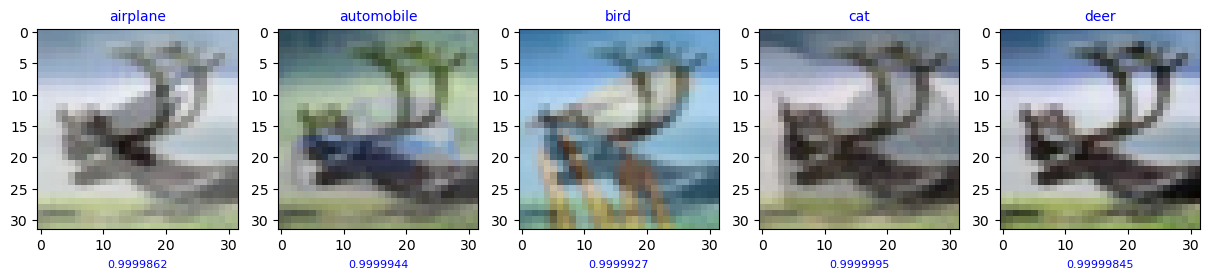

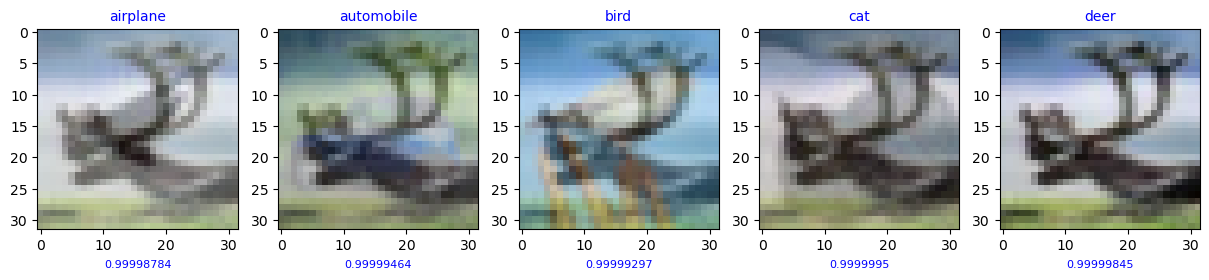

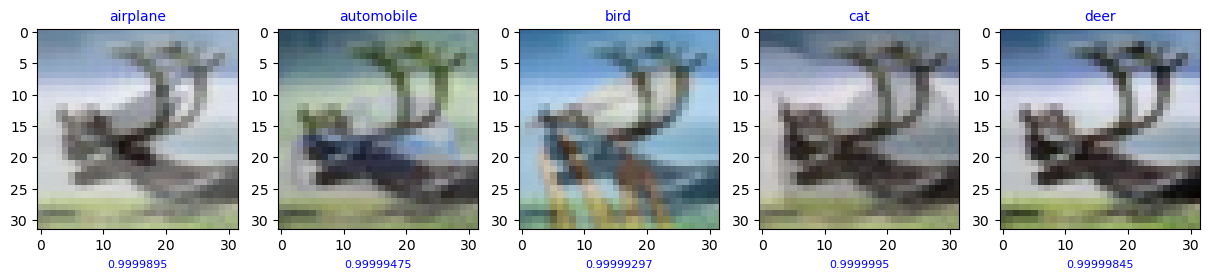

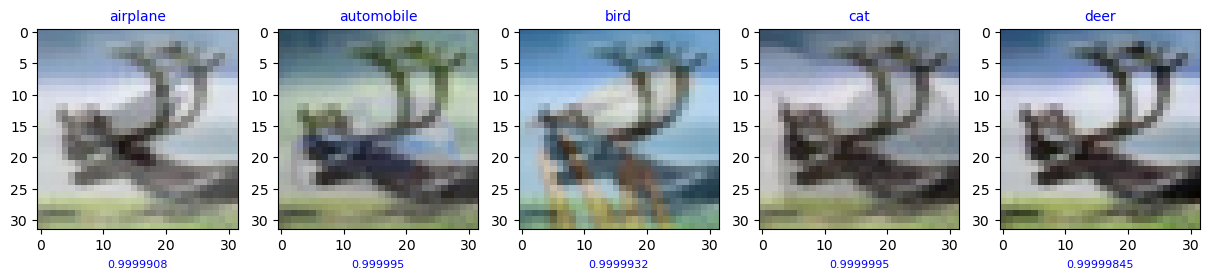

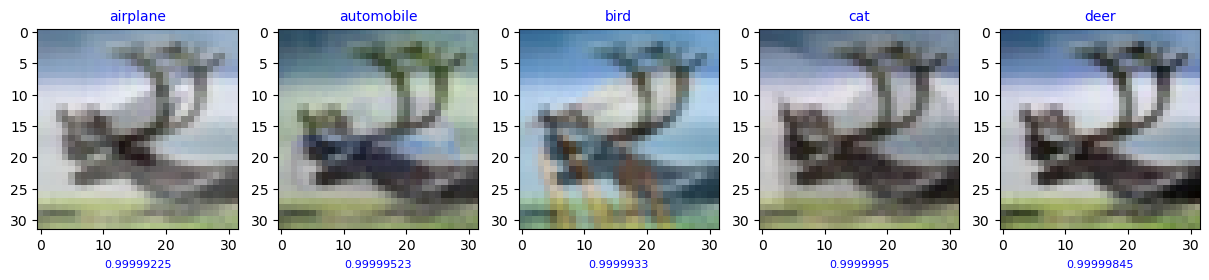

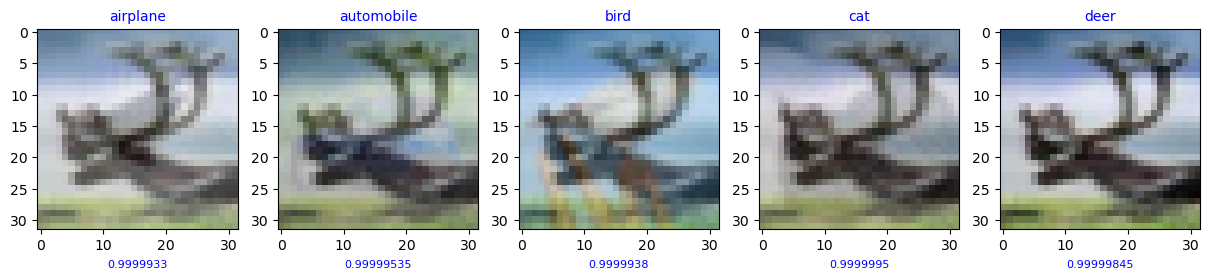

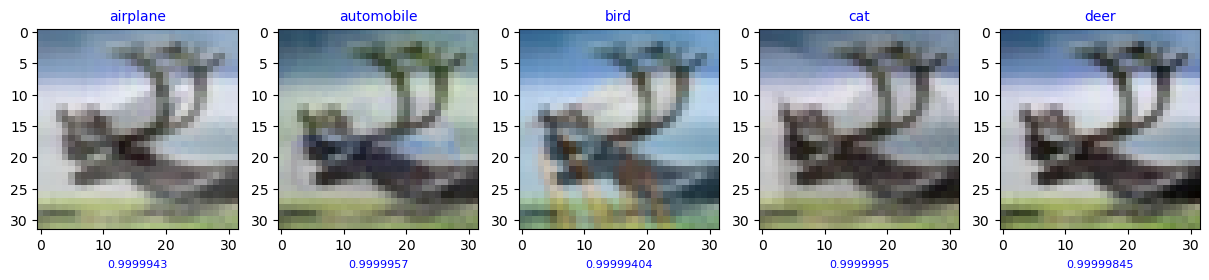

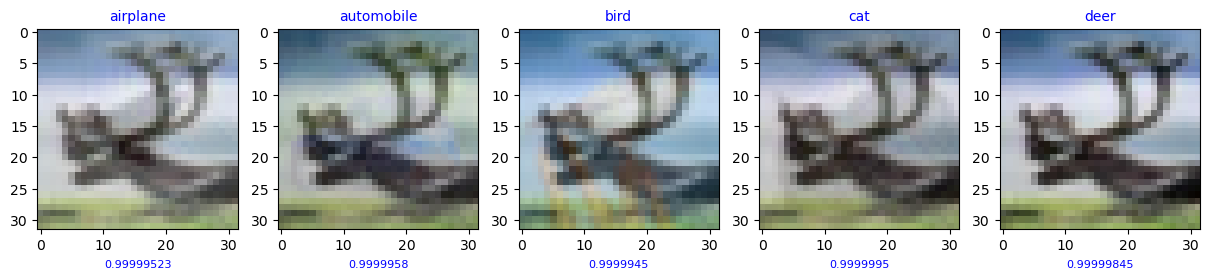

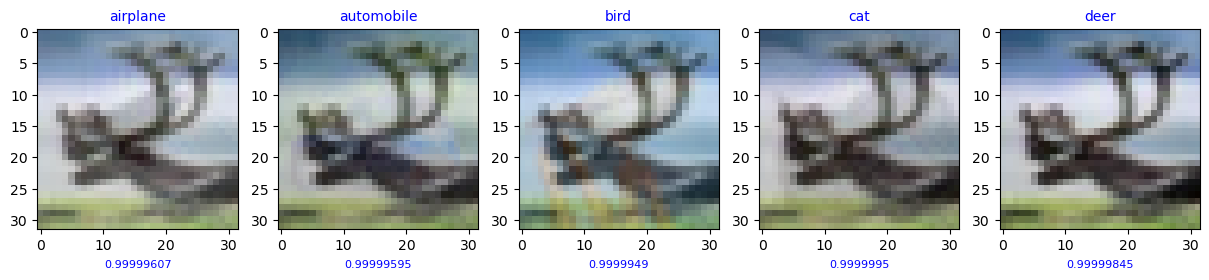

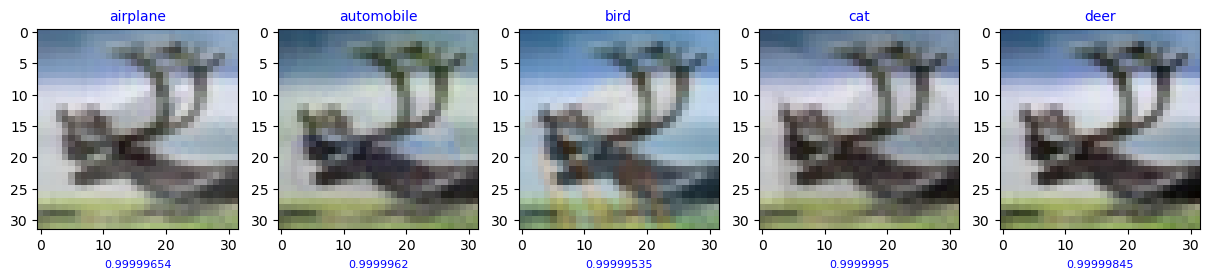

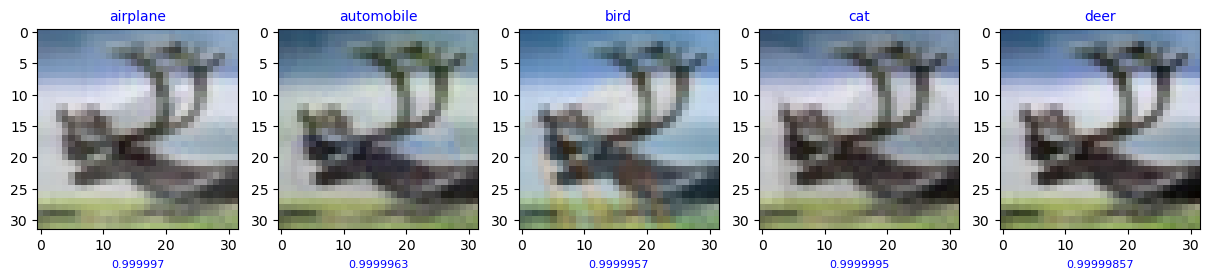

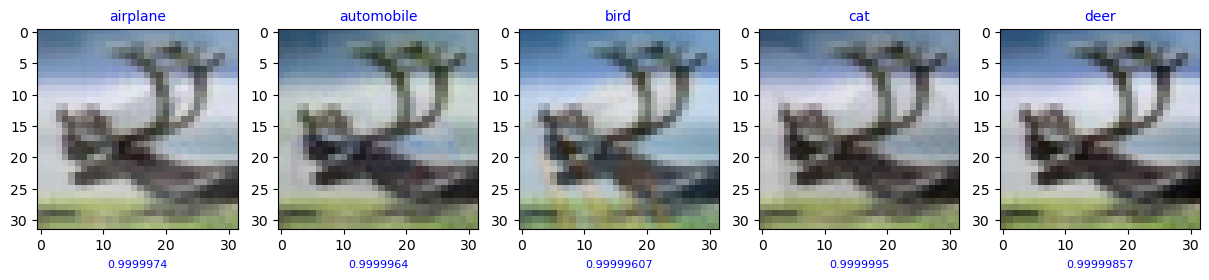

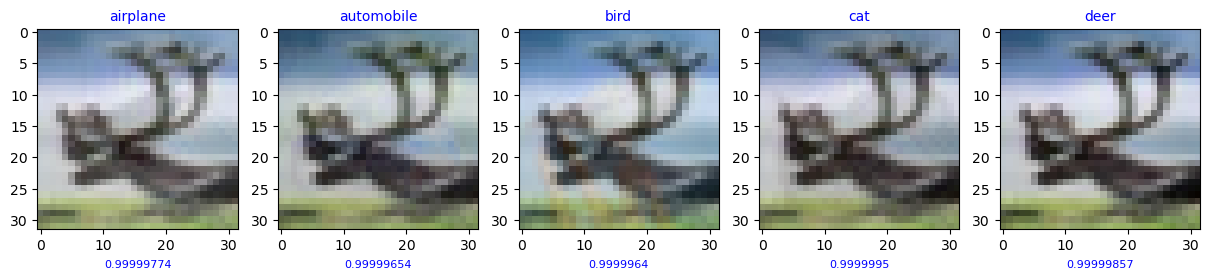

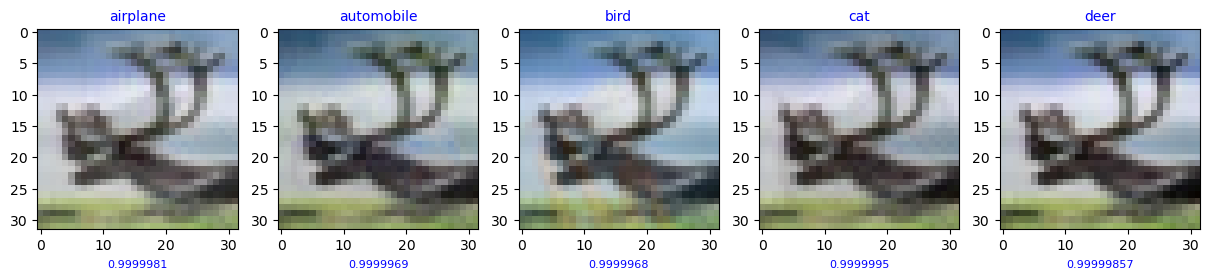

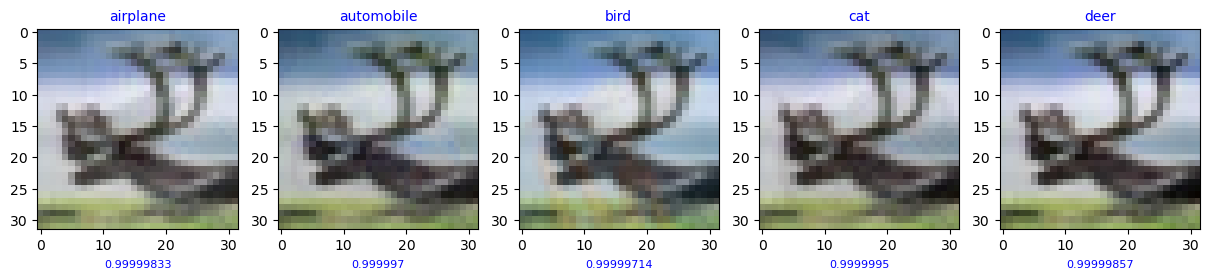

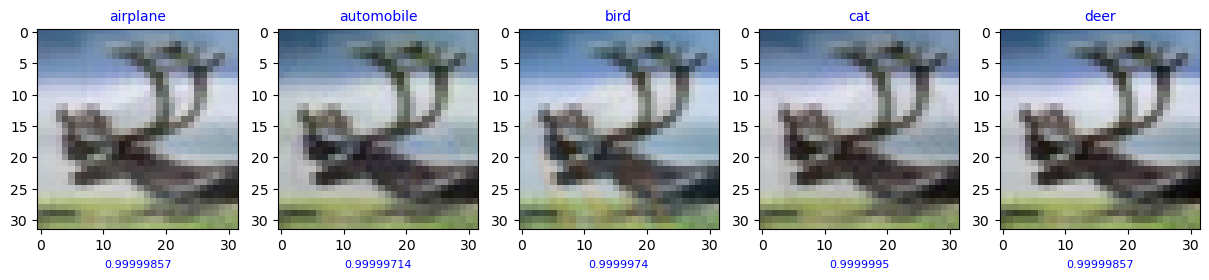

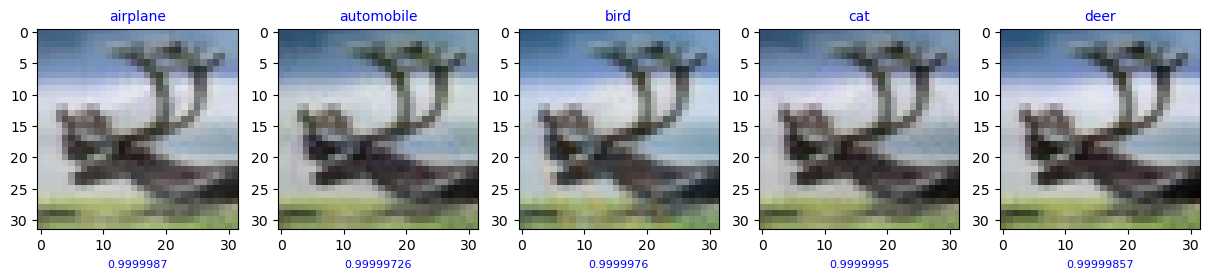

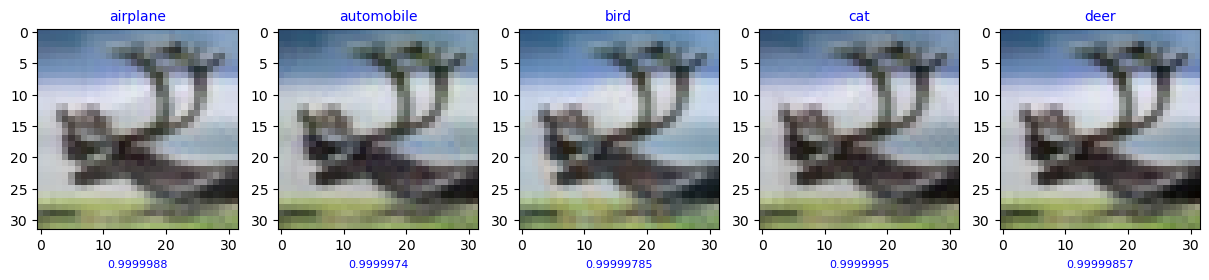

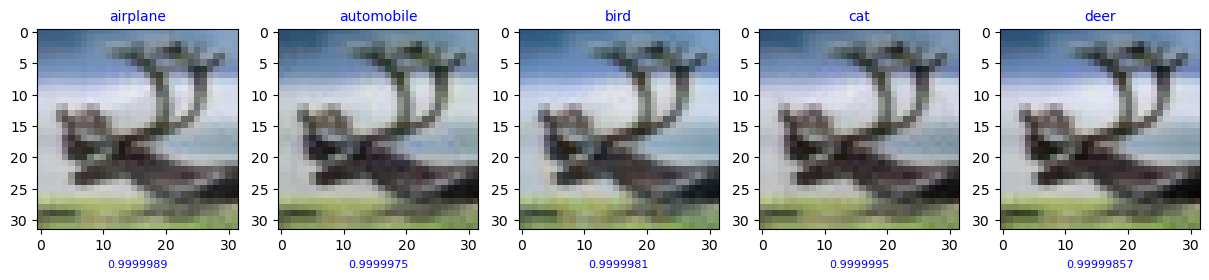

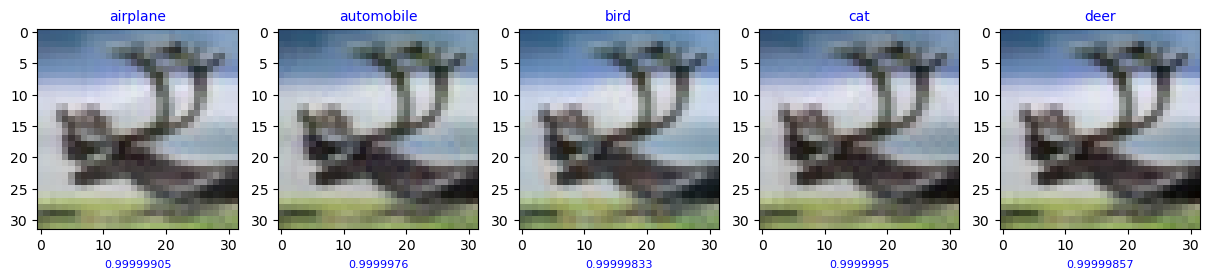

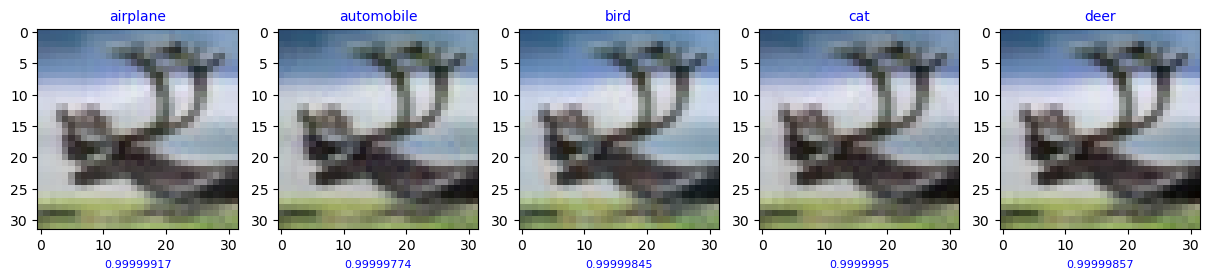

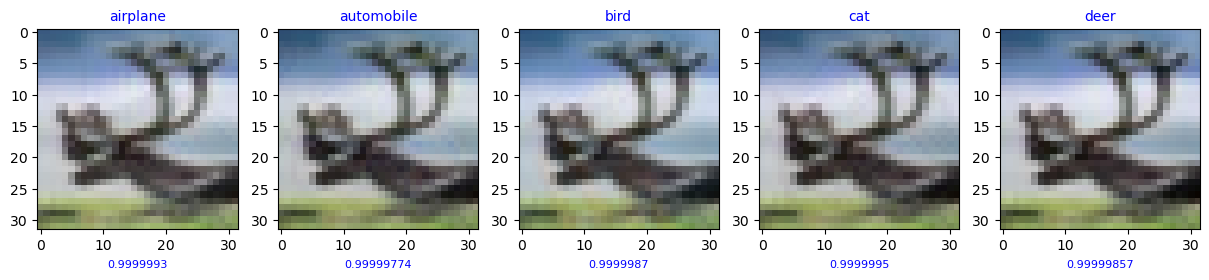

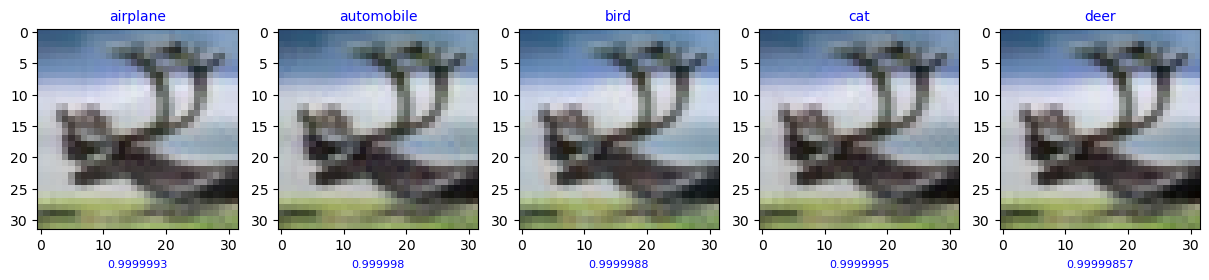

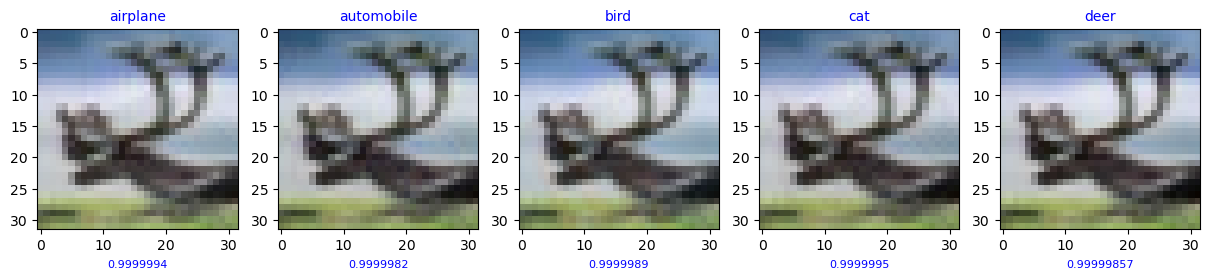

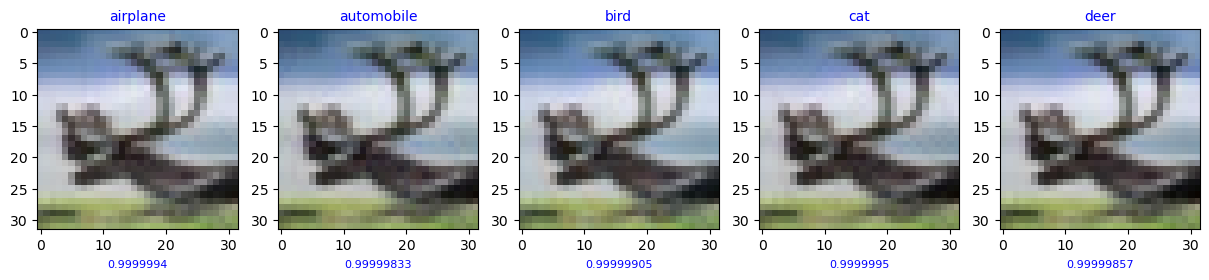

100%|██████████| 1/1 [00:35<00:00, 35.27s/it]


In [76]:
example_loader = [(target_images,  torch.LongTensor(target_classes))]
# print(example_loader)
print('example loader shapes: ', len(example_loader), example_loader[0][0].shape, example_loader[0][1].shape)
all_return_dict = []
num_samples=1000
for i, image in enumerate(target_images):
    print(i)
    accum_dict = dict([])
    for b, data_batch in enumerate(tqdm(example_loader)):
        # print(b) 0
        batch_target_classes = torch.Tensor([target_classes[i]]*len(data_batch[0])).long()   #[i, i, i, i, i]
        batch_target_images = torch.stack([image]*len(data_batch[0]), dim=0)                 #[[image]*5]
        return_dict  = batch_level_set_traversal(model, normalizer, data_batch[0], data_batch[1],
                                                    batch_target_images, batch_target_classes, stepsize=1e-2, iterations=300, device=device, 
                                                    pthresh=0.1, get_widths=True, get_images=True, get_final_imgs=True,
                                                    dfunc_list=[], get_confs_over_path=True, log_step=50)
        # print(return_dict)
        accum_dict = dict_combine(accum_dict, return_dict)
        if len(accum_dict['labels']) >= num_samples:
            break
    all_return_dict.append(accum_dict)

In [77]:
len(all_return_dict)
model, normalizer = load_model_normalizer(1)
source_images = all_return_dict[1]['source_images']
final_images = all_return_dict[3]['final_images']
with torch.no_grad():
    preds = torch.softmax(model(normalizer(source_images.to(device))), dim=-1).cpu().detach().numpy()
    predicted_classes = np.argmax(preds, axis=1)
    confidence_levels = np.max(preds, axis=1)
    print(predicted_classes)
    print(confidence_levels)

[0 1 2 3 4]
[0.9999938  0.999995   0.99999547 0.99999976 0.9999981 ]


-----------------Source Images


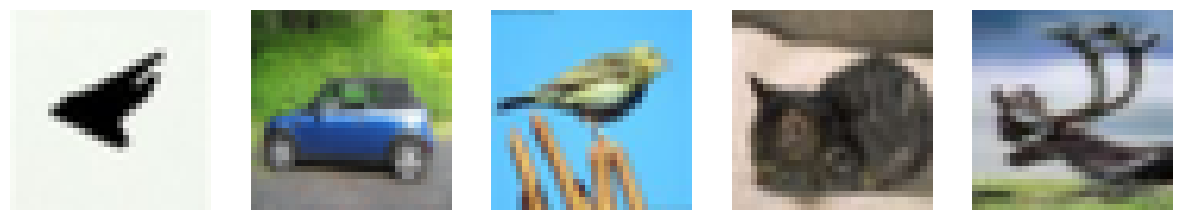

-----------------Final Images


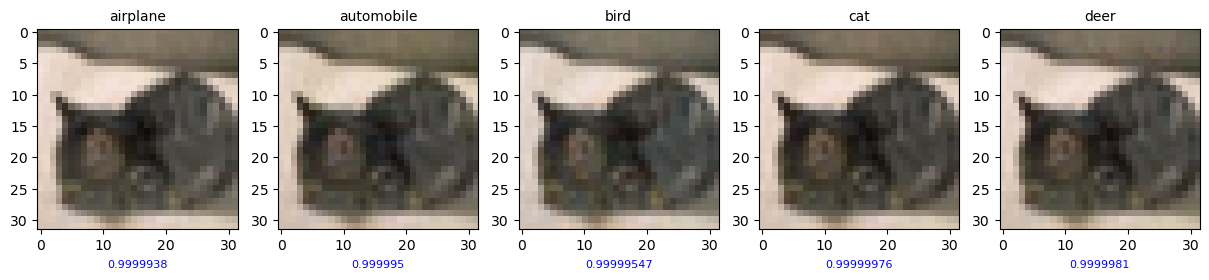

In [78]:
# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

print("-----------------Source Images")
for i in range(5):
    axes[i].imshow(source_images[i].permute(1, 2, 0))
    axes[i].axis('off')

plt.show()

print("-----------------Final Images")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(final_images[i].permute(1, 2, 0))
    axes[i].set_title(classes[predicted_classes[i]], fontsize=10)  # Set title as class name
    axes[i].set_xlabel(confidence_levels[i], fontsize=8, labelpad=5, color='blue', ha='center')

plt.show()